# Proyecto Final - Módulo No Supervisado
**Maestría en Ciencias de Información y las Comunicaciones - Big Data**

---

**Autores**: Álvaro Alejandro Zarabanda Gutiérrez - Youssef Alejandro Ortiz  
**Códigos**: 20251595006 - 20251595XXX   
**Fecha**: Octubre 2025

## Importación de Librerías

Importamos todas las librerías necesarias para el análisis de clustering no supervisado.

In [16]:
# ================================
# IMPORTACIÓN DE LIBRERÍAS
# ================================

# Librerías básicas
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from pathlib import Path
import warnings
from scipy.io import loadmat, savemat

# Librerías de machine learning
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans, AgglomerativeClustering, DBSCAN
from sklearn.metrics import (silhouette_score, calinski_harabasz_score, davies_bouldin_score,
                            adjusted_rand_score, normalized_mutual_info_score, accuracy_score)
from sklearn.model_selection import StratifiedKFold, cross_val_score
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.neighbors import NearestNeighbors
from sklearn.mixture import GaussianMixture
from sklearn.semi_supervised import LabelPropagation, LabelSpreading

# Librerías para manejo de datos desbalanceados
from imblearn.over_sampling import SMOTE
from imblearn.under_sampling import RandomUnderSampler

# Configuración
plt.style.use('seaborn-v0_8')
sns.set_palette("husl")
plt.rcParams['figure.figsize'] = (12, 8)
plt.rcParams['font.size'] = 10
warnings.filterwarnings('ignore')

# Seed para reproducibilidad
np.random.seed(42)

# Configuración de impresión
pd.set_option('display.max_columns', None)
pd.set_option('display.width', None)
pd.set_option('display.max_colwidth', None)

print("Todas las librerías importadas exitosamente")
print("Configuración de visualización establecida")
print("Seed de reproducibilidad configurado (42)")

Todas las librerías importadas exitosamente
Configuración de visualización establecida
Seed de reproducibilidad configurado (42)


## Parte 1: Análisis Exploratorio del Dataset

**Objetivo**: Cargar y caracterizar el dataset `dato_taller.mat` para entender el problema de clasificación binaria.

In [17]:
# ================================
# CARGA Y EXPLORACIÓN DEL DATASET
# ================================

print("Cargando dataset dato_taller.mat...")

# Cargar el archivo .mat
try:
    mat_data = loadmat('dato_taller.mat')
    
    # Mostrar todas las claves disponibles
    print("\nClaves disponibles en el archivo .mat:")
    data_keys = []
    for key in mat_data.keys():
        if not key.startswith('__'):
            print(f"   {key}: {mat_data[key].shape} ({mat_data[key].dtype})")
            data_keys.append(key)
    
    # Identificar automáticamente las matrices de datos
    print(f"\nSe encontraron {len(data_keys)} matrices de datos principales")
    
    # Análisis detallado de cada matriz
    for key in data_keys:
        data = mat_data[key]
        print(f"\nAnálisis de '{key}':")
        print(f"   Dimensiones: {data.shape}")
        print(f"   Tipo de datos: {data.dtype}")
        print(f"   Rango de valores: [{data.min():.4f}, {data.max():.4f}]")
        print(f"   Estadísticas: μ={data.mean():.4f}, σ={data.std():.4f}")
        
        # Si es un vector (posibles etiquetas)
        if len(data.shape) == 2 and min(data.shape) == 1:
            unique_vals = np.unique(data.flatten())
            print(f"   Valores únicos: {unique_vals}")
            print(f"   Distribución: {[(val, np.sum(data.flatten() == val)) for val in unique_vals]}")
    
except Exception as e:
    print(f"Error cargando el dataset: {e}")
    
print(f"\nDataset cargado exitosamente desde: {Path('dato_taller.mat').absolute()}")

Cargando dataset dato_taller.mat...

Claves disponibles en el archivo .mat:
   x_prueba: (10000, 20) (float64)
   x_entena: (1000, 20) (float64)
   y_entrena: (1000, 1) (int16)

Se encontraron 3 matrices de datos principales

Análisis de 'x_prueba':
   Dimensiones: (10000, 20)
   Tipo de datos: float64
   Rango de valores: [-4.7194, 4.7795]
   Estadísticas: μ=0.0028, σ=1.0958

Análisis de 'x_entena':
   Dimensiones: (1000, 20)
   Tipo de datos: float64
   Rango de valores: [-4.0843, 4.4016]
   Estadísticas: μ=0.0117, σ=1.0977

Análisis de 'y_entrena':
   Dimensiones: (1000, 1)
   Tipo de datos: int16
   Rango de valores: [-1.0000, 1.0000]
   Estadísticas: μ=0.0620, σ=0.9981
   Valores únicos: [-1  1]
   Distribución: [(np.int16(-1), np.int64(469)), (np.int16(1), np.int64(531))]

Dataset cargado exitosamente desde: /home/aalejoz25/HDD/Alvaro/Universidad/Posgrado 1/Repositorios/Big_Data/aprendizaje_no_supervisado/trabajo_final/dato_taller.mat


In [18]:
# ================================
# PREPARACIÓN DE DATOS
# ================================

# Extraer matrices de datos
X_train = mat_data['x_entena']  # Datos de entrenamiento
y_train = mat_data['y_entrena'].flatten()  # Etiquetas de entrenamiento 
X_test = mat_data['x_prueba']   # Datos de prueba

print(f"Información de los datos extraídos:")
print(f"X_train: {X_train.shape} - Datos de entrenamiento")
print(f"y_train: {y_train.shape} - Etiquetas de entrenamiento") 
print(f"X_test: {X_test.shape} - Datos de prueba")

# Análisis de distribución de clases
unique_classes, class_counts = np.unique(y_train, return_counts=True)
print(f"\nDistribución de clases en entrenamiento:")
for clase, count in zip(unique_classes, class_counts):
    print(f"  Clase {clase}: {count} muestras ({count/len(y_train)*100:.1f}%)")

# Crear DataFrame para análisis
df_train = pd.DataFrame(X_train, columns=[f'Feature_{i+1}' for i in range(X_train.shape[1])])
df_train['target'] = y_train

print(f"\nDatos preparados exitosamente")
print(f"DataFrame creado con {df_train.shape[0]} muestras y {df_train.shape[1]-1} características")

Información de los datos extraídos:
X_train: (1000, 20) - Datos de entrenamiento
y_train: (1000,) - Etiquetas de entrenamiento
X_test: (10000, 20) - Datos de prueba

Distribución de clases en entrenamiento:
  Clase -1: 469 muestras (46.9%)
  Clase 1: 531 muestras (53.1%)

Datos preparados exitosamente
DataFrame creado con 1000 muestras y 20 características


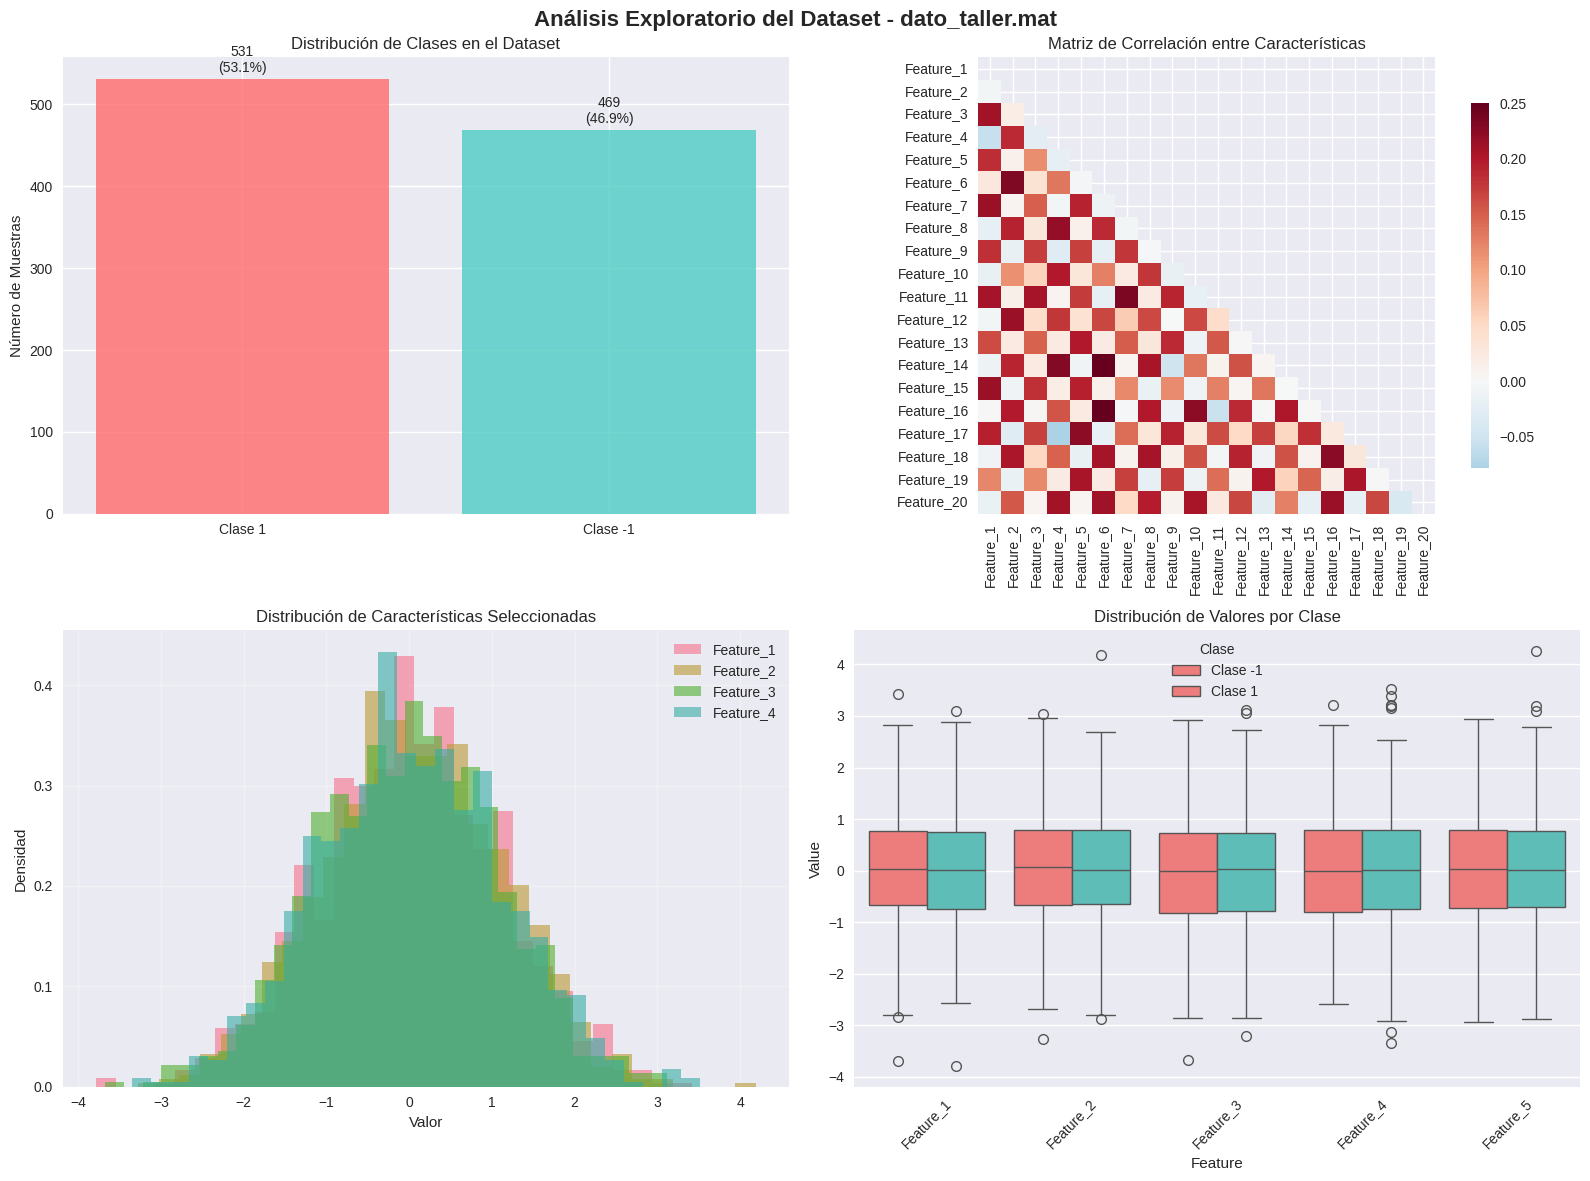

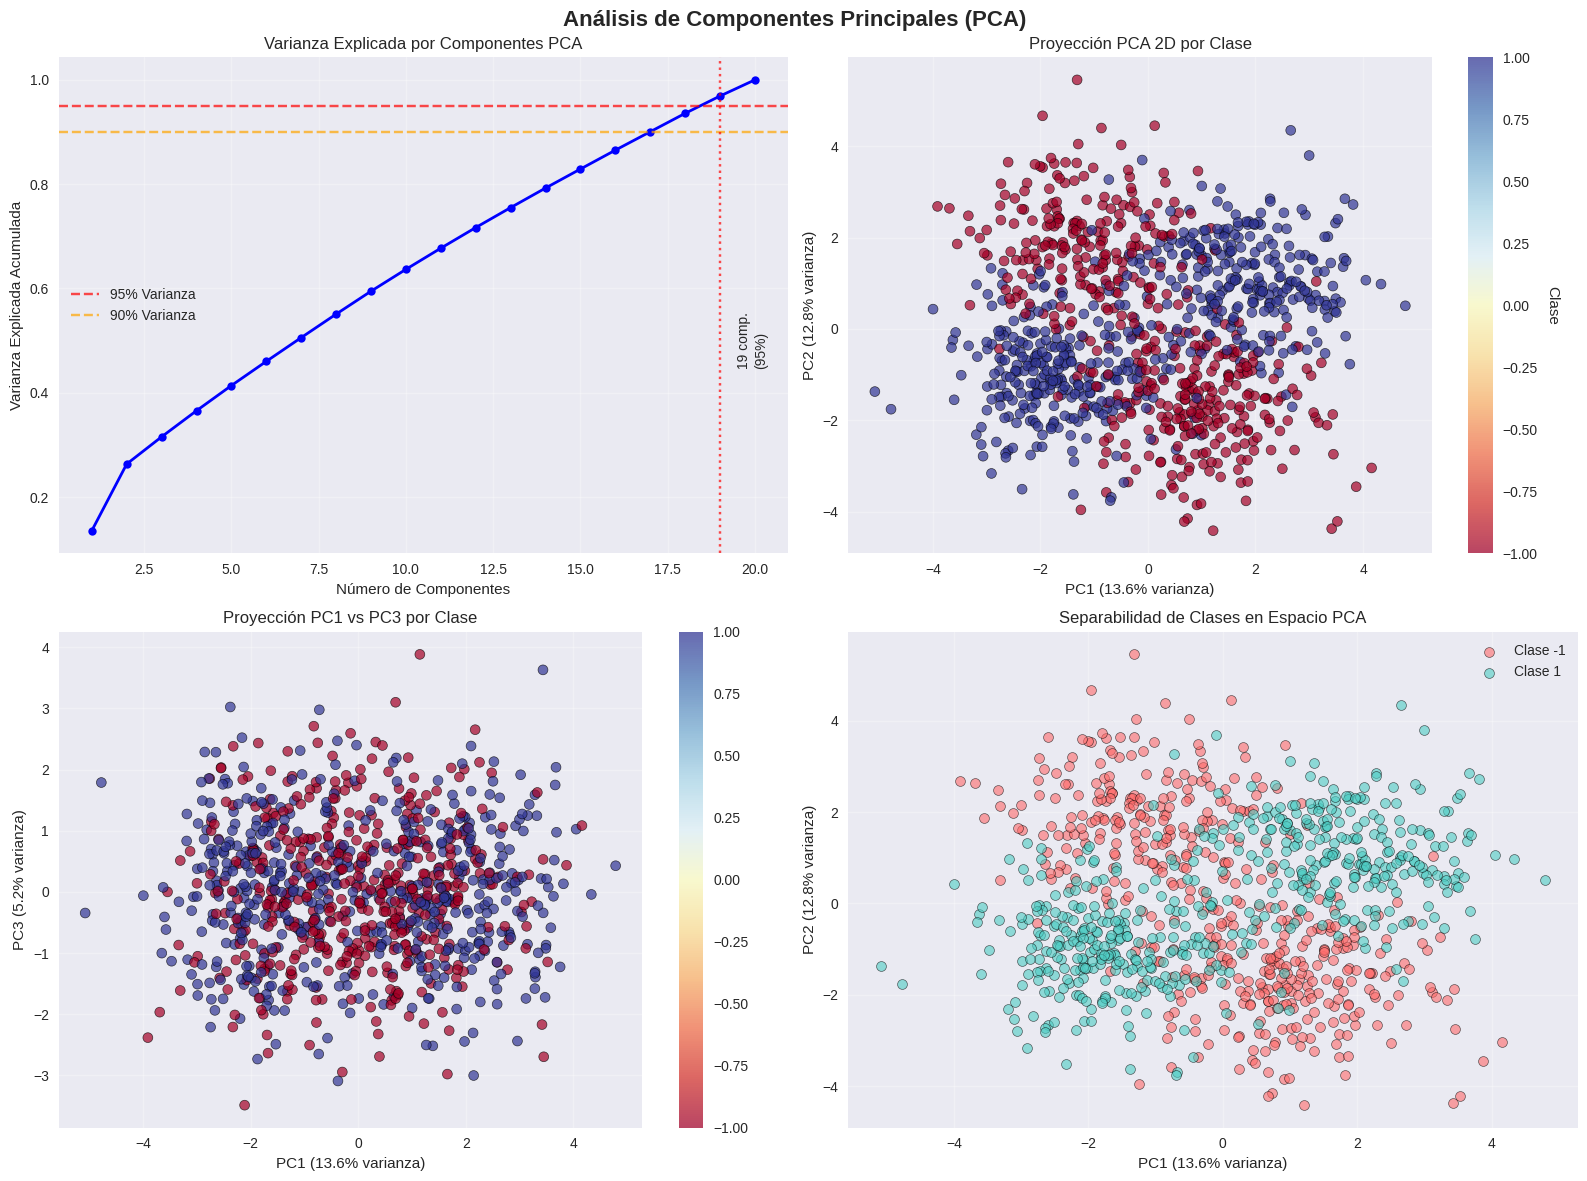

RESUMEN ESTADÍSTICO POR CLASE:
Estadísticas de las primeras 5 características:
       Feature_1                                                          \
           count    mean     std     min     25%     50%     75%     max   
target                                                                     
-1         469.0  0.0239  1.1080 -3.6934 -0.6643  0.0364  0.7741  3.4218   
 1         531.0  0.0237  1.0744 -3.7894 -0.7492  0.0185  0.7450  3.1034   

       Feature_2                                                          \
           count    mean     std     min     25%     50%     75%     max   
target                                                                     
-1         469.0  0.0344  1.0974 -3.2750 -0.6704  0.0687  0.7836  3.0440   
 1         531.0  0.0664  1.0668 -2.8737 -0.6523  0.0155  0.7842  4.1892   

       Feature_3                                                          \
           count    mean     std     min     25%     50%     75%     max   
target 

In [19]:

# Configurar el directorio de figuras
figures_dir = Path('figures')
figures_dir.mkdir(exist_ok=True)

# Figura 1: Análisis de distribuciones y correlaciones
fig1, axes1 = plt.subplots(2, 2, figsize=(16, 12))
fig1.suptitle('Análisis Exploratorio del Dataset - dato_taller.mat', fontsize=16, fontweight='bold')

# 1. Distribución de clases
ax1 = axes1[0, 0]
class_counts = df_train['target'].value_counts()
colors = ['#FF6B6B', '#4ECDC4']
bars = ax1.bar([f'Clase {int(k)}' for k in class_counts.index], class_counts.values, color=colors, alpha=0.8)
ax1.set_title('Distribución de Clases en el Dataset')
ax1.set_ylabel('Número de Muestras')
for i, bar in enumerate(bars):
    height = bar.get_height()
    percentage = height / len(y_train) * 100
    ax1.text(bar.get_x() + bar.get_width()/2., height + 5, 
             f'{height}\n({percentage:.1f}%)', ha='center', va='bottom')

# 2. Matriz de correlación de todas las características
ax2 = axes1[0, 1]
correlation_matrix = df_train.iloc[:, :-1].corr()
mask = np.triu(np.ones_like(correlation_matrix, dtype=bool))
sns.heatmap(correlation_matrix, mask=mask, annot=False, cmap='RdBu_r', center=0, 
            square=True, ax=ax2, cbar_kws={'shrink': 0.8})
ax2.set_title('Matriz de Correlación entre Características')

# 3. Distribución de algunas características clave
ax3 = axes1[1, 0]
features_sample = ['Feature_1', 'Feature_2', 'Feature_3', 'Feature_4']
for i, feature in enumerate(features_sample):
    ax3.hist(df_train[feature], bins=30, alpha=0.6, label=feature, density=True)
ax3.set_title('Distribución de Características Seleccionadas')
ax3.set_xlabel('Valor')
ax3.set_ylabel('Densidad')
ax3.legend()
ax3.grid(True, alpha=0.3)

# 4. Boxplot comparativo por clase
ax4 = axes1[1, 1]
features_to_plot = ['Feature_1', 'Feature_2', 'Feature_3', 'Feature_4', 'Feature_5']
df_melted = df_train[features_to_plot + ['target']].melt(id_vars=['target'], 
                                                         var_name='Feature', 
                                                         value_name='Value')
sns.boxplot(data=df_melted, x='Feature', y='Value', hue='target', ax=ax4, 
            palette=['#FF6B6B', '#4ECDC4'])
ax4.set_title('Distribución de Valores por Clase')
ax4.tick_params(axis='x', rotation=45)
ax4.legend(title='Clase', labels=['Clase -1', 'Clase 1'])

plt.tight_layout()
plt.savefig(figures_dir / 'figura_01_analisis_exploratorio_general.png', dpi=300, bbox_inches='tight')
plt.show()

# Figura 2: Análisis PCA detallado con scatter plots
fig2, axes2 = plt.subplots(2, 2, figsize=(16, 12))
fig2.suptitle('Análisis de Componentes Principales (PCA)', fontsize=16, fontweight='bold')

# Realizar PCA completo
pca_full = PCA(random_state=42)
X_train_pca_full = pca_full.fit_transform(X_train)

# 1. Varianza explicada acumulada
ax1 = axes2[0, 0]
cumsum_var = np.cumsum(pca_full.explained_variance_ratio_)
ax1.plot(range(1, len(cumsum_var) + 1), cumsum_var, 'bo-', linewidth=2, markersize=6)
ax1.axhline(y=0.95, color='r', linestyle='--', alpha=0.7, label='95% Varianza')
ax1.axhline(y=0.90, color='orange', linestyle='--', alpha=0.7, label='90% Varianza')
ax1.set_xlabel('Número de Componentes')
ax1.set_ylabel('Varianza Explicada Acumulada')
ax1.set_title('Varianza Explicada por Componentes PCA')
ax1.grid(True, alpha=0.3)
ax1.legend()

# Encontrar número de componentes para 95%
n_components_95 = np.argmax(cumsum_var >= 0.95) + 1
ax1.axvline(x=n_components_95, color='r', linestyle=':', alpha=0.7)
ax1.text(n_components_95 + 0.5, 0.5, f'{n_components_95} comp.\n(95%)', rotation=90, va='center')

# 2. PCA 2D Scatter Plot
ax2 = axes2[0, 1]
scatter = ax2.scatter(X_train_pca_full[:, 0], X_train_pca_full[:, 1], 
                     c=y_train, cmap='RdYlBu', alpha=0.7, s=50, edgecolors='black', linewidth=0.5)
ax2.set_xlabel(f'PC1 ({pca_full.explained_variance_ratio_[0]:.1%} varianza)')
ax2.set_ylabel(f'PC2 ({pca_full.explained_variance_ratio_[1]:.1%} varianza)')
ax2.set_title('Proyección PCA 2D por Clase')
ax2.grid(True, alpha=0.3)
cbar = plt.colorbar(scatter, ax=ax2)
cbar.set_label('Clase', rotation=270, labelpad=15)

# 3. PCA 3D proyectado en PC1 vs PC3
ax3 = axes2[1, 0]
scatter3 = ax3.scatter(X_train_pca_full[:, 0], X_train_pca_full[:, 2], 
                      c=y_train, cmap='RdYlBu', alpha=0.7, s=50, edgecolors='black', linewidth=0.5)
ax3.set_xlabel(f'PC1 ({pca_full.explained_variance_ratio_[0]:.1%} varianza)')
ax3.set_ylabel(f'PC3 ({pca_full.explained_variance_ratio_[2]:.1%} varianza)')
ax3.set_title('Proyección PC1 vs PC3 por Clase')
ax3.grid(True, alpha=0.3)
plt.colorbar(scatter3, ax=ax3)

# 4. Separabilidad por clase en PCA
ax4 = axes2[1, 1]
class_minus1 = X_train_pca_full[y_train == -1]
class_plus1 = X_train_pca_full[y_train == 1]

ax4.scatter(class_minus1[:, 0], class_minus1[:, 1], 
           c='#FF6B6B', alpha=0.6, s=50, label='Clase -1', edgecolors='black', linewidth=0.5)
ax4.scatter(class_plus1[:, 0], class_plus1[:, 1], 
           c='#4ECDC4', alpha=0.6, s=50, label='Clase 1', edgecolors='black', linewidth=0.5)

ax4.set_xlabel(f'PC1 ({pca_full.explained_variance_ratio_[0]:.1%} varianza)')
ax4.set_ylabel(f'PC2 ({pca_full.explained_variance_ratio_[1]:.1%} varianza)')
ax4.set_title('Separabilidad de Clases en Espacio PCA')
ax4.legend()
ax4.grid(True, alpha=0.3)

plt.tight_layout()
plt.savefig(figures_dir / 'figura_02_analisis_pca_detallado.png', dpi=300, bbox_inches='tight')
plt.show()

# Resumen estadístico mejorado
print("RESUMEN ESTADÍSTICO POR CLASE:")
print("="*60)
summary_stats = df_train.groupby('target').describe()
print("Estadísticas de las primeras 5 características:")
print(summary_stats[['Feature_1', 'Feature_2', 'Feature_3', 'Feature_4', 'Feature_5']].round(4))

print(f"\nINFORMACIÓN PCA:")
print(f"Componentes necesarios para 95% varianza: {n_components_95}")
print(f"Componentes necesarios para 90% varianza: {np.argmax(cumsum_var >= 0.90) + 1}")
print(f"Varianza explicada por primeros 3 PCs: {pca_full.explained_variance_ratio_[:3].sum():.1%}")

# Análisis de separabilidad
from scipy.stats import ttest_ind
print(f"\nANÁLISIS DE SEPARABILIDAD (t-test entre clases):")
print("-" * 50)
for i in range(5):
    feature_name = f'Feature_{i+1}'
    class_minus1_values = df_train[df_train['target'] == -1][feature_name]
    class_plus1_values = df_train[df_train['target'] == 1][feature_name]
    t_stat, p_value = ttest_ind(class_minus1_values, class_plus1_values)
    significance = "***" if p_value < 0.001 else "**" if p_value < 0.01 else "*" if p_value < 0.05 else ""
    print(f"{feature_name}: t={t_stat:.3f}, p={p_value:.4f} {significance}")

print(f"\nDataset listo para clustering. Dimensiones:")
print(f"- Original: {X_train.shape}")
print(f"- Clases balanceadas: {(y_train == -1).sum()} vs {(y_train == 1).sum()}")

ANÁLISIS EXPLORATORIO DE DATOS DE PRUEBA
Información básica de X_test:
  Dimensiones: (10000, 20)
  Tipo de datos: float64
  Rango de valores: [-4.7194, 4.7795]
  Estadísticas globales: μ=0.0028, σ=1.0958


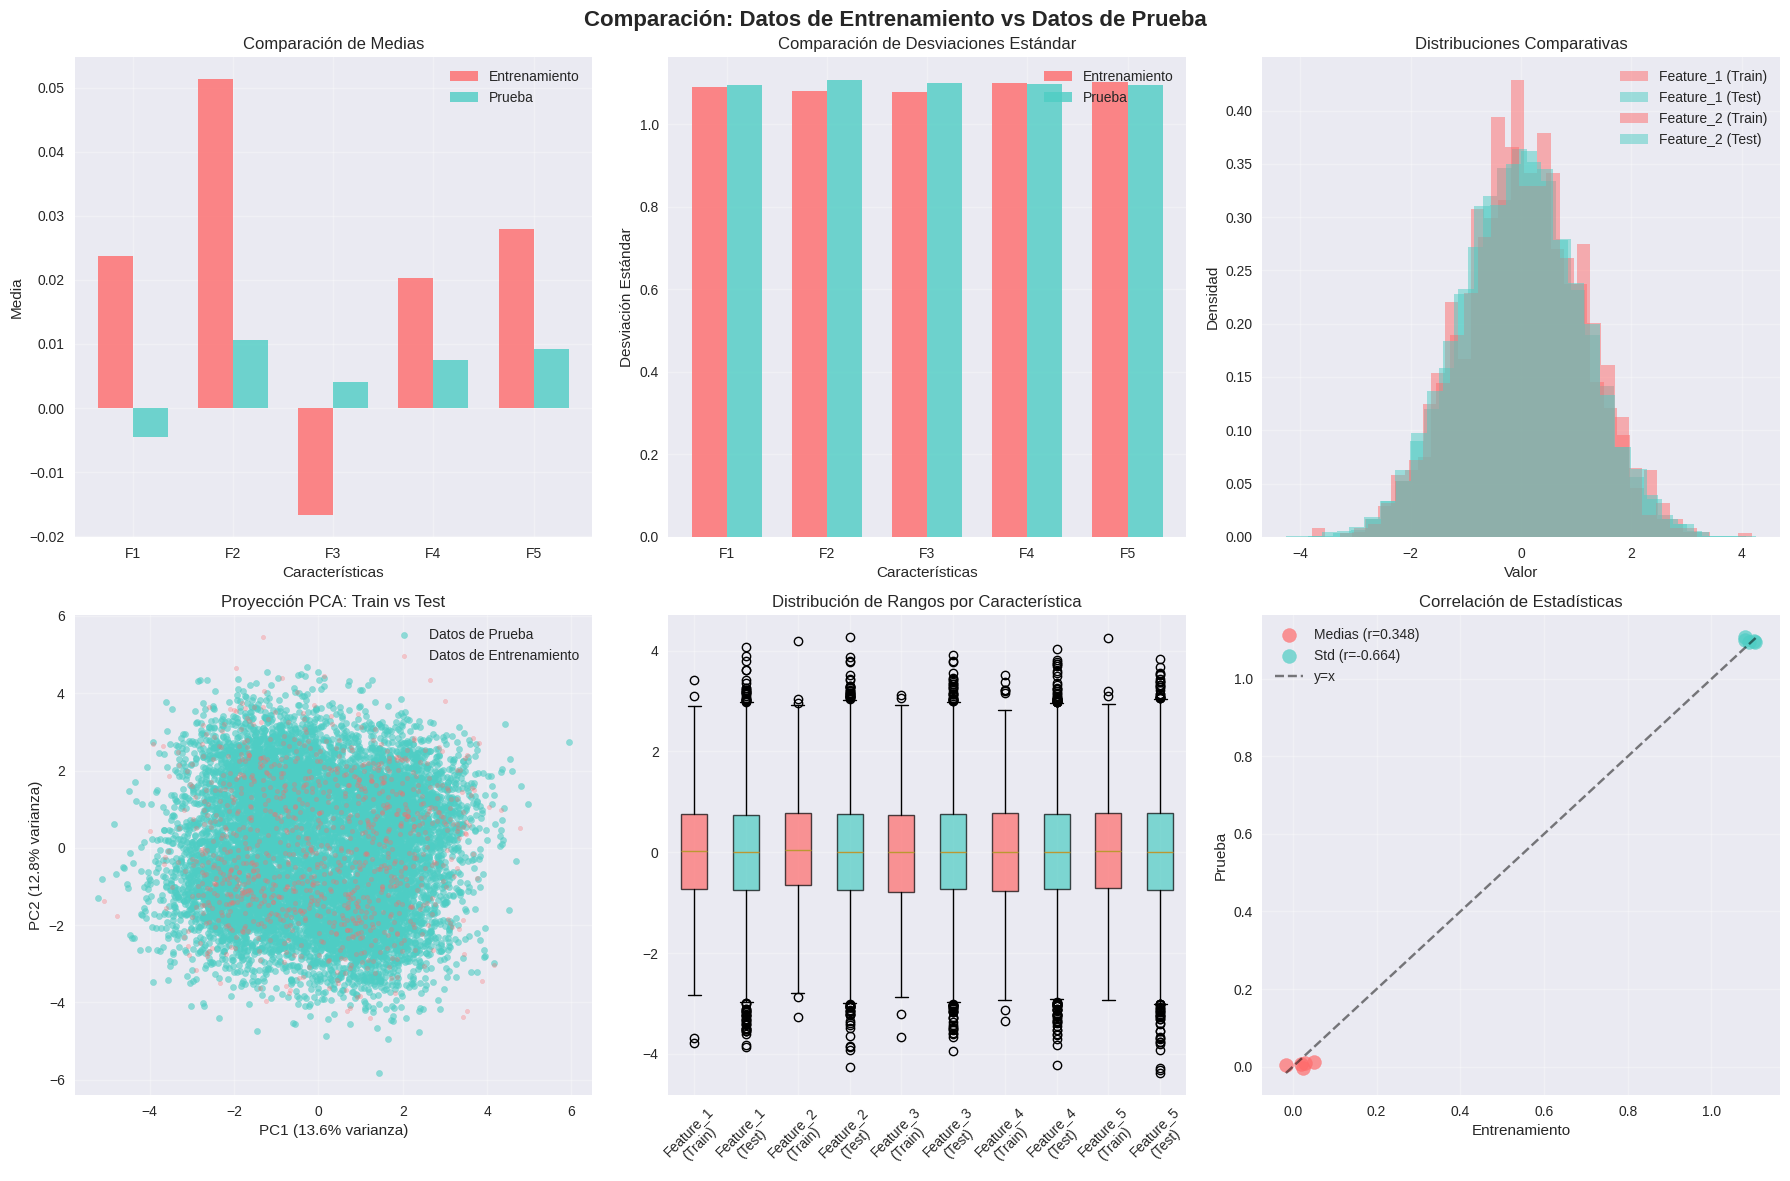


COMPARACIÓN ESTADÍSTICA DETALLADA:
--------------------------------------------------
Test de Kolmogorov-Smirnov (distribuciones similares):
  Feature_1: KS=0.0282, p=0.4582 -> Similares: SÍ
  Feature_2: KS=0.0317, p=0.3150 -> Similares: SÍ
  Feature_3: KS=0.0187, p=0.9034 -> Similares: SÍ
  Feature_4: KS=0.0163, p=0.9665 -> Similares: SÍ
  Feature_5: KS=0.0186, p=0.9067 -> Similares: SÍ

Test t para diferencias en medias:
  Feature_1: t=0.7822, p=0.4341 -> Diferentes: NO
  Feature_2: t=1.1118, p=0.2662 -> Diferentes: NO
  Feature_3: t=-0.5685, p=0.5697 -> Diferentes: NO
  Feature_4: t=0.3550, p=0.7226 -> Diferentes: NO
  Feature_5: t=0.5131, p=0.6079 -> Diferentes: NO

RESUMEN DE COMPATIBILIDAD:
  Correlación de medias Train-Test: 0.3485
  Correlación de std Train-Test: -0.6645
  Rango de valores Train: [-4.0843, 4.4016]
  Rango de valores Test: [-4.7194, 4.7795]

VERIFICACIÓN DE NORMALIZACIÓN:
  X_train normalizado: μ=-0.000000, σ=1.000000
  X_test normalizado: μ=-0.008134, σ=1.0000

In [20]:
# ================================
# ANÁLISIS EXPLORATORIO DE DATOS DE PRUEBA (X_test)
# ================================

print("ANÁLISIS EXPLORATORIO DE DATOS DE PRUEBA")
print("="*60)

# Crear DataFrame para datos de prueba
df_test = pd.DataFrame(X_test, columns=[f'Feature_{i+1}' for i in range(X_test.shape[1])])

print(f"Información básica de X_test:")
print(f"  Dimensiones: {X_test.shape}")
print(f"  Tipo de datos: {X_test.dtype}")
print(f"  Rango de valores: [{X_test.min():.4f}, {X_test.max():.4f}]")
print(f"  Estadísticas globales: μ={X_test.mean():.4f}, σ={X_test.std():.4f}")

# Figura comparativa entre datos de entrenamiento y prueba
fig3, axes3 = plt.subplots(2, 3, figsize=(18, 12))
fig3.suptitle('Comparación: Datos de Entrenamiento vs Datos de Prueba', fontsize=16, fontweight='bold')

# 1. Estadísticas descriptivas comparativas
ax1 = axes3[0, 0]
stats_train = df_train.iloc[:, :-1].describe().loc[['mean', 'std']].T
stats_test = df_test.describe().loc[['mean', 'std']].T

# Comparar medias
features_sample = ['Feature_1', 'Feature_2', 'Feature_3', 'Feature_4', 'Feature_5']
x_pos = np.arange(len(features_sample))
width = 0.35

means_train = [stats_train.loc[f, 'mean'] for f in features_sample]
means_test = [stats_test.loc[f, 'mean'] for f in features_sample]

bars1 = ax1.bar(x_pos - width/2, means_train, width, label='Entrenamiento', alpha=0.8, color='#FF6B6B')
bars2 = ax1.bar(x_pos + width/2, means_test, width, label='Prueba', alpha=0.8, color='#4ECDC4')

ax1.set_xlabel('Características')
ax1.set_ylabel('Media')
ax1.set_title('Comparación de Medias')
ax1.set_xticks(x_pos)
ax1.set_xticklabels([f'F{i}' for i in range(1, 6)])
ax1.legend()
ax1.grid(True, alpha=0.3)

# 2. Comparación de desviaciones estándar
ax2 = axes3[0, 1]
stds_train = [stats_train.loc[f, 'std'] for f in features_sample]
stds_test = [stats_test.loc[f, 'std'] for f in features_sample]

bars1 = ax2.bar(x_pos - width/2, stds_train, width, label='Entrenamiento', alpha=0.8, color='#FF6B6B')
bars2 = ax2.bar(x_pos + width/2, stds_test, width, label='Prueba', alpha=0.8, color='#4ECDC4')

ax2.set_xlabel('Características')
ax2.set_ylabel('Desviación Estándar')
ax2.set_title('Comparación de Desviaciones Estándar')
ax2.set_xticks(x_pos)
ax2.set_xticklabels([f'F{i}' for i in range(1, 6)])
ax2.legend()
ax2.grid(True, alpha=0.3)

# 3. Distribuciones superpuestas
ax3 = axes3[0, 2]
for i, feature in enumerate(['Feature_1', 'Feature_2']):
    ax3.hist(df_train[feature], bins=30, alpha=0.5, label=f'{feature} (Train)', density=True, color='#FF6B6B')
    ax3.hist(df_test[feature], bins=30, alpha=0.5, label=f'{feature} (Test)', density=True, color='#4ECDC4', linestyle='--')

ax3.set_title('Distribuciones Comparativas')
ax3.set_xlabel('Valor')
ax3.set_ylabel('Densidad')
ax3.legend()
ax3.grid(True, alpha=0.3)

# 4. PCA en datos de prueba
ax4 = axes3[1, 0]
# Aplicar el mismo PCA entrenado con datos de entrenamiento
X_test_pca_comparison = pca_full.transform(X_test)

ax4.scatter(X_test_pca_comparison[:, 0], X_test_pca_comparison[:, 1], 
           alpha=0.6, s=20, color='#4ECDC4', label='Datos de Prueba')
ax4.scatter(X_train_pca_full[:, 0], X_train_pca_full[:, 1], 
           alpha=0.3, s=10, color='#FF6B6B', label='Datos de Entrenamiento')

ax4.set_xlabel(f'PC1 ({pca_full.explained_variance_ratio_[0]:.1%} varianza)')
ax4.set_ylabel(f'PC2 ({pca_full.explained_variance_ratio_[1]:.1%} varianza)')
ax4.set_title('Proyección PCA: Train vs Test')
ax4.legend()
ax4.grid(True, alpha=0.3)

# 5. Boxplot comparativo de rangos
ax5 = axes3[1, 1]
# Preparar datos para boxplot
data_for_boxplot = []
labels_for_boxplot = []

for feature in features_sample:
    data_for_boxplot.extend([df_train[feature].values, df_test[feature].values])
    labels_for_boxplot.extend([f'{feature}\n(Train)', f'{feature}\n(Test)'])

# Crear boxplot
bp = ax5.boxplot(data_for_boxplot, labels=labels_for_boxplot, patch_artist=True)

# Colorear las cajas alternadamente
colors = ['#FF6B6B', '#4ECDC4'] * len(features_sample)
for patch, color in zip(bp['boxes'], colors):
    patch.set_facecolor(color)
    patch.set_alpha(0.7)

ax5.set_title('Distribución de Rangos por Característica')
ax5.tick_params(axis='x', rotation=45)
ax5.grid(True, alpha=0.3)

# 6. Correlación entre estadísticas de train y test
ax6 = axes3[1, 2]
# Calcular correlaciones entre medias y desviaciones
correlation_means = np.corrcoef(means_train, means_test)[0, 1]
correlation_stds = np.corrcoef(stds_train, stds_test)[0, 1]

ax6.scatter(means_train, means_test, s=100, alpha=0.7, color='#FF6B6B', label=f'Medias (r={correlation_means:.3f})')
ax6.scatter(stds_train, stds_test, s=100, alpha=0.7, color='#4ECDC4', label=f'Std (r={correlation_stds:.3f})')

# Línea diagonal para referencia
min_val = min(min(means_train + stds_train), min(means_test + stds_test))
max_val = max(max(means_train + stds_train), max(means_test + stds_test))
ax6.plot([min_val, max_val], [min_val, max_val], 'k--', alpha=0.5, label='y=x')

ax6.set_xlabel('Entrenamiento')
ax6.set_ylabel('Prueba')
ax6.set_title('Correlación de Estadísticas')
ax6.legend()
ax6.grid(True, alpha=0.3)

plt.tight_layout()
plt.savefig(figures_dir / 'figura_03_comparacion_train_test.png', dpi=300, bbox_inches='tight')
plt.show()

# Análisis estadístico detallado
print(f"\nCOMPARACIÓN ESTADÍSTICA DETALLADA:")
print("-" * 50)

# Test de Kolmogorov-Smirnov para comparar distribuciones
from scipy.stats import ks_2samp, ttest_ind

print(f"Test de Kolmogorov-Smirnov (distribuciones similares):")
for feature in features_sample:
    ks_stat, p_value = ks_2samp(df_train[feature], df_test[feature])
    similar = "SÍ" if p_value > 0.05 else "NO"
    print(f"  {feature}: KS={ks_stat:.4f}, p={p_value:.4f} -> Similares: {similar}")

print(f"\nTest t para diferencias en medias:")
for feature in features_sample:
    t_stat, p_value = ttest_ind(df_train[feature], df_test[feature])
    different = "SÍ" if p_value < 0.05 else "NO"
    print(f"  {feature}: t={t_stat:.4f}, p={p_value:.4f} -> Diferentes: {different}")

# Resumen de compatibilidad
print(f"\nRESUMEN DE COMPATIBILIDAD:")
print(f"  Correlación de medias Train-Test: {correlation_means:.4f}")
print(f"  Correlación de std Train-Test: {correlation_stds:.4f}")
print(f"  Rango de valores Train: [{X_train.min():.4f}, {X_train.max():.4f}]")
print(f"  Rango de valores Test: [{X_test.min():.4f}, {X_test.max():.4f}]")

# Verificar normalización consistente
scaler_check = StandardScaler()
X_train_check = scaler_check.fit_transform(X_train)
X_test_check = scaler_check.transform(X_test)

print(f"\nVERIFICACIÓN DE NORMALIZACIÓN:")
print(f"  X_train normalizado: μ={X_train_check.mean():.6f}, σ={X_train_check.std():.6f}")
print(f"  X_test normalizado: μ={X_test_check.mean():.6f}, σ={X_test_check.std():.6f}")

print(f"\nDatos de prueba analizados exitosamente")
print(f"Compatibilidad Train-Test verificada para aplicación de clustering")

## Parte 2: Implementación de Algoritmos de Clustering

**Objetivo**: Implementar y optimizar mínimo 3 técnicas de clustering no supervisado.

In [21]:
# ================================
# PREPROCESAMIENTO PARA CLUSTERING
# ================================

# Normalizar los datos (esencial para clustering)
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

print("Datos normalizados exitosamente")
print(f"   Media de X_train_scaled: {X_train_scaled.mean():.6f}")
print(f"   Desviación estándar de X_train_scaled: {X_train_scaled.std():.6f}")

# Aplicar PCA para reducción de dimensionalidad (opcional para visualización)
pca = PCA(random_state=42)
X_train_pca = pca.fit_transform(X_train_scaled)
X_test_pca = pca.transform(X_test_scaled)

# Análisis de componentes principales
cumsum_var = np.cumsum(pca.explained_variance_ratio_)
n_components_95 = np.argmax(cumsum_var >= 0.95) + 1

print(f"\nAnálisis PCA:")
print(f"   Componentes para 95% varianza: {n_components_95}")
print(f"   Varianza de primeros 5 PCs: {pca.explained_variance_ratio_[:5].round(3)}")

# Crear versión reducida para clustering eficiente
pca_optimal = PCA(n_components=n_components_95, random_state=42)
X_train_pca_optimal = pca_optimal.fit_transform(X_train_scaled)
X_test_pca_optimal = pca_optimal.transform(X_test_scaled)

print(f"\nDatasets preparados:")
print(f"   Original: {X_train_scaled.shape}")
print(f"   PCA reducido: {X_train_pca_optimal.shape}")

Datos normalizados exitosamente
   Media de X_train_scaled: -0.000000
   Desviación estándar de X_train_scaled: 1.000000

Análisis PCA:
   Componentes para 95% varianza: 19
   Varianza de primeros 5 PCs: [0.135 0.128 0.052 0.05  0.049]

Datasets preparados:
   Original: (1000, 20)
   PCA reducido: (1000, 19)


In [22]:
# ================================
# ALGORITMO 1: K-MEANS CLUSTERING
# ================================

print("IMPLEMENTANDO K-MEANS CLUSTERING")
print("="*50)

# Función para evaluar diferentes números de clusters
def evaluate_kmeans(X, k_range=range(2, 11)):
    """Evalúa K-means para diferentes valores de k"""
    results = {
        'k_values': [],
        'inertia': [],
        'silhouette': [],
        'calinski_harabasz': [],
        'davies_bouldin': []
    }
    
    for k in k_range:
        # Entrenar K-means
        kmeans = KMeans(n_clusters=k, random_state=42, n_init=10)
        labels = kmeans.fit_predict(X)
        
        # Calcular métricas
        inertia = kmeans.inertia_
        sil_score = silhouette_score(X, labels)
        ch_score = calinski_harabasz_score(X, labels)
        db_score = davies_bouldin_score(X, labels)
        
        # Almacenar resultados
        results['k_values'].append(k)
        results['inertia'].append(inertia)
        results['silhouette'].append(sil_score)
        results['calinski_harabasz'].append(ch_score)
        results['davies_bouldin'].append(db_score)
        
        print(f"K={k}: Silhouette={sil_score:.4f}, Calinski-Harabasz={ch_score:.2f}, Davies-Bouldin={db_score:.4f}")
    
    return results

# Evaluar K-means en datos originales y PCA
print("\nEvaluación en datos originales normalizados:")
kmeans_results_original = evaluate_kmeans(X_train_scaled)

print("\nEvaluación en datos con PCA:")
kmeans_results_pca = evaluate_kmeans(X_train_pca_optimal)

# Encontrar el k óptimo basado en silhouette score
k_optimal_original = kmeans_results_original['k_values'][np.argmax(kmeans_results_original['silhouette'])]
k_optimal_pca = kmeans_results_pca['k_values'][np.argmax(kmeans_results_pca['silhouette'])]

print(f"\nK óptimo en datos originales: {k_optimal_original}")
print(f"K óptimo en datos PCA: {k_optimal_pca}")

# Entrenar modelos finales con k óptimo
kmeans_final_original = KMeans(n_clusters=k_optimal_original, random_state=42, n_init=10)
kmeans_labels_original = kmeans_final_original.fit_predict(X_train_scaled)

kmeans_final_pca = KMeans(n_clusters=k_optimal_pca, random_state=42, n_init=10)
kmeans_labels_pca = kmeans_final_pca.fit_predict(X_train_pca_optimal)

print("\nModelos K-means entrenados exitosamente")

IMPLEMENTANDO K-MEANS CLUSTERING

Evaluación en datos originales normalizados:
K=2: Silhouette=0.0930, Calinski-Harabasz=109.51, Davies-Bouldin=2.9818
K=3: Silhouette=0.0814, Calinski-Harabasz=93.44, Davies-Bouldin=2.6705
K=4: Silhouette=0.0701, Calinski-Harabasz=80.18, Davies-Bouldin=2.9038
K=5: Silhouette=0.0593, Calinski-Harabasz=65.43, Davies-Bouldin=3.2683
K=4: Silhouette=0.0701, Calinski-Harabasz=80.18, Davies-Bouldin=2.9038
K=5: Silhouette=0.0593, Calinski-Harabasz=65.43, Davies-Bouldin=3.2683
K=6: Silhouette=0.0558, Calinski-Harabasz=56.15, Davies-Bouldin=3.4620
K=7: Silhouette=0.0498, Calinski-Harabasz=49.60, Davies-Bouldin=3.5542
K=6: Silhouette=0.0558, Calinski-Harabasz=56.15, Davies-Bouldin=3.4620
K=7: Silhouette=0.0498, Calinski-Harabasz=49.60, Davies-Bouldin=3.5542
K=8: Silhouette=0.0453, Calinski-Harabasz=44.49, Davies-Bouldin=3.5854
K=9: Silhouette=0.0443, Calinski-Harabasz=41.06, Davies-Bouldin=3.6475
K=8: Silhouette=0.0453, Calinski-Harabasz=44.49, Davies-Bouldin=3.58

In [23]:
# ================================
# ALGORITMO 2: CLUSTERING JERÁRQUICO
# ================================

print("\nIMPLEMENTANDO CLUSTERING JERÁRQUICO")
print("="*50)

# Función para evaluar clustering jerárquico
def evaluate_hierarchical(X, k_range=range(2, 11), linkage_methods=['ward', 'complete', 'average']):
    """Evalúa clustering jerárquico con diferentes métodos de enlace"""
    results = {}
    
    for linkage in linkage_methods:
        print(f"\nEvaluando {linkage} linkage:")
        results[linkage] = {
            'k_values': [],
            'silhouette': [],
            'calinski_harabasz': [],
            'davies_bouldin': []
        }
        
        for k in k_range:
            # Entrenar clustering jerárquico
            hierarchical = AgglomerativeClustering(n_clusters=k, linkage=linkage)
            labels = hierarchical.fit_predict(X)
            
            # Calcular métricas
            sil_score = silhouette_score(X, labels)
            ch_score = calinski_harabasz_score(X, labels)
            db_score = davies_bouldin_score(X, labels)
            
            # Almacenar resultados
            results[linkage]['k_values'].append(k)
            results[linkage]['silhouette'].append(sil_score)
            results[linkage]['calinski_harabasz'].append(ch_score)
            results[linkage]['davies_bouldin'].append(db_score)
            
            print(f"  K={k}: Silhouette={sil_score:.4f}, CH={ch_score:.2f}, DB={db_score:.4f}")
    
    return results

# Evaluar clustering jerárquico en datos originales
print("Evaluación en datos originales normalizados:")
hierarchical_results = evaluate_hierarchical(X_train_scaled)

# Encontrar la mejor configuración
best_linkage = None
best_k_hierarchical = None
best_score_hierarchical = -1

for linkage in hierarchical_results:
    scores = hierarchical_results[linkage]['silhouette']
    max_idx = np.argmax(scores)
    if scores[max_idx] > best_score_hierarchical:
        best_score_hierarchical = scores[max_idx]
        best_linkage = linkage
        best_k_hierarchical = hierarchical_results[linkage]['k_values'][max_idx]

print(f"\nMejor configuración: {best_linkage} linkage, K={best_k_hierarchical}")
print(f"Mejor silhouette score: {best_score_hierarchical:.4f}")

# Entrenar modelo final jerárquico
hierarchical_final = AgglomerativeClustering(n_clusters=best_k_hierarchical, linkage=best_linkage)
hierarchical_labels = hierarchical_final.fit_predict(X_train_scaled)

print("Modelo de clustering jerárquico entrenado exitosamente")


IMPLEMENTANDO CLUSTERING JERÁRQUICO
Evaluación en datos originales normalizados:

Evaluando ward linkage:
  K=2: Silhouette=0.0768, CH=89.01, DB=3.2535
  K=3: Silhouette=0.0593, CH=71.41, DB=3.0958
  K=4: Silhouette=0.0476, CH=63.26, DB=3.1190
  K=5: Silhouette=0.0358, CH=51.55, DB=4.1687
  K=6: Silhouette=0.0344, CH=44.11, DB=3.8569
  K=7: Silhouette=0.0299, CH=38.94, DB=3.9791
  K=8: Silhouette=0.0207, CH=35.16, DB=4.2888
  K=9: Silhouette=0.0201, CH=32.33, DB=4.1579
  K=6: Silhouette=0.0344, CH=44.11, DB=3.8569
  K=7: Silhouette=0.0299, CH=38.94, DB=3.9791
  K=8: Silhouette=0.0207, CH=35.16, DB=4.2888
  K=9: Silhouette=0.0201, CH=32.33, DB=4.1579
  K=10: Silhouette=0.0172, CH=30.11, DB=4.0847

Evaluando complete linkage:
  K=2: Silhouette=0.0617, CH=67.60, DB=3.5434
  K=3: Silhouette=0.0453, CH=63.64, DB=3.3856
  K=4: Silhouette=0.0307, CH=49.13, DB=4.4232
  K=5: Silhouette=0.0274, CH=44.64, DB=4.5644
  K=10: Silhouette=0.0172, CH=30.11, DB=4.0847

Evaluando complete linkage:
  K=2

In [24]:
# ================================
# ALGORITMO 3: DBSCAN CLUSTERING
# ================================

print("\nIMPLEMENTANDO DBSCAN CLUSTERING")
print("="*50)

from sklearn.neighbors import NearestNeighbors

# Función para estimar eps usando k-nearest neighbors
def estimate_eps(X, k=4):
    """Estima el valor óptimo de eps para DBSCAN"""
    nbrs = NearestNeighbors(n_neighbors=k).fit(X)
    distances, indices = nbrs.kneighbors(X)
    distances = np.sort(distances[:, k-1], axis=0)
    
    # Encontrar el "codo" en la curva de distancias
    # Usar el percentil 90 como estimación conservadora
    eps_estimate = np.percentile(distances, 90)
    return eps_estimate, distances

# Estimar eps
eps_estimate, distances = estimate_eps(X_train_scaled, k=4)
print(f"Eps estimado: {eps_estimate:.4f}")

# Función para evaluar DBSCAN con diferentes parámetros
def evaluate_dbscan(X, eps_range, min_samples_range):
    """Evalúa DBSCAN con diferentes parámetros"""
    results = {
        'eps': [],
        'min_samples': [],
        'n_clusters': [],
        'n_noise': [],
        'silhouette': [],
        'calinski_harabasz': [],
        'davies_bouldin': []
    }
    
    for eps in eps_range:
        for min_samples in min_samples_range:
            # Entrenar DBSCAN
            dbscan = DBSCAN(eps=eps, min_samples=min_samples)
            labels = dbscan.fit_predict(X)
            
            # Calcular número de clusters y ruido
            n_clusters = len(set(labels)) - (1 if -1 in labels else 0)
            n_noise = list(labels).count(-1)
            
            # Solo calcular métricas si hay al menos 2 clusters
            if n_clusters >= 2:
                # Filtrar puntos de ruido para métricas
                mask = labels != -1
                if mask.sum() > 0:
                    X_filtered = X[mask]
                    labels_filtered = labels[mask]
                    
                    if len(set(labels_filtered)) >= 2:
                        sil_score = silhouette_score(X_filtered, labels_filtered)
                        ch_score = calinski_harabasz_score(X_filtered, labels_filtered)
                        db_score = davies_bouldin_score(X_filtered, labels_filtered)
                    else:
                        sil_score = ch_score = db_score = -1
                else:
                    sil_score = ch_score = db_score = -1
            else:
                sil_score = ch_score = db_score = -1
            
            # Almacenar resultados
            results['eps'].append(eps)
            results['min_samples'].append(min_samples)
            results['n_clusters'].append(n_clusters)
            results['n_noise'].append(n_noise)
            results['silhouette'].append(sil_score)
            results['calinski_harabasz'].append(ch_score)
            results['davies_bouldin'].append(db_score)
            
            print(f"eps={eps:.3f}, min_samples={min_samples}: {n_clusters} clusters, {n_noise} ruido, Sil={sil_score:.4f}")
    
    return results

# Evaluar DBSCAN con diferentes parámetros
eps_range = np.linspace(eps_estimate * 0.5, eps_estimate * 2.0, 6)
min_samples_range = [3, 4, 5, 6, 8, 10]

dbscan_results = evaluate_dbscan(X_train_scaled, eps_range, min_samples_range)

# Encontrar la mejor configuración DBSCAN
valid_indices = [i for i, score in enumerate(dbscan_results['silhouette']) if score > 0]

if valid_indices:
    best_idx = valid_indices[np.argmax([dbscan_results['silhouette'][i] for i in valid_indices])]
    best_eps = dbscan_results['eps'][best_idx]
    best_min_samples = dbscan_results['min_samples'][best_idx]
    best_score_dbscan = dbscan_results['silhouette'][best_idx]
    
    print(f"\nMejor configuración DBSCAN: eps={best_eps:.4f}, min_samples={best_min_samples}")
    print(f"Mejor silhouette score: {best_score_dbscan:.4f}")
    
    # Entrenar modelo final DBSCAN
    dbscan_final = DBSCAN(eps=best_eps, min_samples=best_min_samples)
    dbscan_labels = dbscan_final.fit_predict(X_train_scaled)
    
    n_clusters_dbscan = len(set(dbscan_labels)) - (1 if -1 in dbscan_labels else 0)
    n_noise_dbscan = list(dbscan_labels).count(-1)
    
    print(f"DBSCAN final: {n_clusters_dbscan} clusters, {n_noise_dbscan} puntos de ruido")
else:
    print("No se encontró configuración válida para DBSCAN")
    # Usar configuración por defecto
    dbscan_final = DBSCAN(eps=eps_estimate, min_samples=5)
    dbscan_labels = dbscan_final.fit_predict(X_train_scaled)
    best_score_dbscan = -1

print("Modelo DBSCAN entrenado exitosamente")


IMPLEMENTANDO DBSCAN CLUSTERING
Eps estimado: 4.3219
eps=2.161, min_samples=3: 0 clusters, 1000 ruido, Sil=-1.0000
eps=2.161, min_samples=4: 0 clusters, 1000 ruido, Sil=-1.0000
eps=2.161, min_samples=5: 0 clusters, 1000 ruido, Sil=-1.0000
eps=2.161, min_samples=6: 0 clusters, 1000 ruido, Sil=-1.0000
eps=2.161, min_samples=8: 0 clusters, 1000 ruido, Sil=-1.0000
eps=2.161, min_samples=10: 0 clusters, 1000 ruido, Sil=-1.0000
eps=3.458, min_samples=3: 9 clusters, 516 ruido, Sil=-0.1144
eps=3.458, min_samples=4: 4 clusters, 575 ruido, Sil=-0.0606
eps=3.458, min_samples=5: 3 clusters, 617 ruido, Sil=0.0066
eps=3.458, min_samples=6: 3 clusters, 659 ruido, Sil=-0.0552
eps=3.458, min_samples=8: 1 clusters, 727 ruido, Sil=-1.0000
eps=3.458, min_samples=10: 1 clusters, 785 ruido, Sil=-1.0000
eps=4.754, min_samples=3: 1 clusters, 5 ruido, Sil=-1.0000
eps=4.754, min_samples=4: 1 clusters, 5 ruido, Sil=-1.0000
eps=4.754, min_samples=5: 1 clusters, 5 ruido, Sil=-1.0000
eps=4.754, min_samples=6: 1 cl

## Parte 3: Etiquetado de Clusters y Evaluación Semi-supervisada

**Objetivo**: Etiquetar cada cluster según la clase mayoritaria de las muestras etiquetadas y evaluar la calidad de los algoritmos de clustering.

In [25]:
# ================================
# FUNCIÓN PARA ETIQUETAR CLUSTERS
# ================================

def label_clusters(cluster_labels, true_labels):
    """
    Etiqueta cada cluster según la clase mayoritaria de las muestras etiquetadas
    
    Parameters:
    -----------
    cluster_labels : array-like
        Etiquetas de clusters asignadas por el algoritmo
    true_labels : array-like
        Etiquetas verdaderas de las muestras
        
    Returns:
    --------
    predicted_labels : array-like
        Etiquetas predichas después del mapeo
    cluster_mapping : dict
        Mapeo de cluster_id -> etiqueta_mayoritaria
    cluster_purity : dict
        Pureza de cada cluster (porcentaje de la clase mayoritaria)
    """
    from collections import Counter
    
    cluster_mapping = {}
    cluster_purity = {}
    predicted_labels = np.copy(cluster_labels)
    
    # Obtener clusters únicos (excluyendo ruido en DBSCAN)
    unique_clusters = np.unique(cluster_labels)
    if -1 in unique_clusters:
        unique_clusters = unique_clusters[unique_clusters != -1]
    
    for cluster_id in unique_clusters:
        # Obtener muestras del cluster
        cluster_mask = cluster_labels == cluster_id
        cluster_true_labels = true_labels[cluster_mask]
        
        if len(cluster_true_labels) > 0:
            # Encontrar la clase mayoritaria
            label_counts = Counter(cluster_true_labels)
            majority_label = label_counts.most_common(1)[0][0]
            majority_count = label_counts.most_common(1)[0][1]
            
            # Calcular pureza del cluster
            purity = majority_count / len(cluster_true_labels)
            
            # Guardar mapeo y pureza
            cluster_mapping[cluster_id] = majority_label
            cluster_purity[cluster_id] = purity
            
            # Asignar etiqueta mayoritaria a todas las muestras del cluster
            predicted_labels[cluster_mask] = majority_label
    
    # Para puntos de ruido en DBSCAN, asignar etiqueta más común
    if -1 in cluster_labels:
        noise_mask = cluster_labels == -1
        most_common_label = Counter(true_labels).most_common(1)[0][0]
        predicted_labels[noise_mask] = most_common_label
        cluster_mapping[-1] = most_common_label
        cluster_purity[-1] = 0.0  # Ruido tiene pureza 0
    
    return predicted_labels, cluster_mapping, cluster_purity

# ================================
# EVALUACIÓN DE ALGORITMOS DE CLUSTERING
# ================================

print("ETIQUETADO Y EVALUACIÓN DE CLUSTERS")
print("="*60)

# Diccionario para almacenar resultados
clustering_results = {}

# 1. K-MEANS (mejor configuración)
print("\n1. EVALUANDO K-MEANS")
print("-" * 40)

kmeans_pred, kmeans_mapping, kmeans_purity = label_clusters(kmeans_labels_original, y_train)

# Métricas de evaluación
kmeans_accuracy = accuracy_score(y_train, kmeans_pred)
kmeans_ari = adjusted_rand_score(y_train, kmeans_labels_original)
kmeans_nmi = normalized_mutual_info_score(y_train, kmeans_labels_original)

print(f"K-means (K={k_optimal_original}):")
print(f"  Accuracy: {kmeans_accuracy:.4f}")
print(f"  Adjusted Rand Index: {kmeans_ari:.4f}")
print(f"  Normalized Mutual Info: {kmeans_nmi:.4f}")
print(f"  Silhouette Score: {max(kmeans_results_original['silhouette']):.4f}")

print(f"\nMapeo de clusters K-means:")
for cluster_id, label in kmeans_mapping.items():
    purity = kmeans_purity[cluster_id]
    print(f"  Cluster {cluster_id} -> Clase {label} (pureza: {purity:.3f})")

clustering_results['kmeans'] = {
    'accuracy': kmeans_accuracy,
    'ari': kmeans_ari,
    'nmi': kmeans_nmi,
    'silhouette': max(kmeans_results_original['silhouette']),
    'n_clusters': k_optimal_original,
    'mapping': kmeans_mapping,
    'purity': kmeans_purity,
    'predicted_labels': kmeans_pred
}

# 2. CLUSTERING JERÁRQUICO (mejor configuración)
print(f"\n2. EVALUANDO CLUSTERING JERÁRQUICO")
print("-" * 40)

hierarchical_pred, hierarchical_mapping, hierarchical_purity = label_clusters(hierarchical_labels, y_train)

# Métricas de evaluación
hierarchical_accuracy = accuracy_score(y_train, hierarchical_pred)
hierarchical_ari = adjusted_rand_score(y_train, hierarchical_labels)
hierarchical_nmi = normalized_mutual_info_score(y_train, hierarchical_labels)

print(f"Clustering Jerárquico ({best_linkage}, K={best_k_hierarchical}):")
print(f"  Accuracy: {hierarchical_accuracy:.4f}")
print(f"  Adjusted Rand Index: {hierarchical_ari:.4f}")
print(f"  Normalized Mutual Info: {hierarchical_nmi:.4f}")
print(f"  Silhouette Score: {best_score_hierarchical:.4f}")

print(f"\nMapeo de clusters Jerárquico:")
for cluster_id, label in hierarchical_mapping.items():
    purity = hierarchical_purity[cluster_id]
    print(f"  Cluster {cluster_id} -> Clase {label} (pureza: {purity:.3f})")

clustering_results['hierarchical'] = {
    'accuracy': hierarchical_accuracy,
    'ari': hierarchical_ari,
    'nmi': hierarchical_nmi,
    'silhouette': best_score_hierarchical,
    'n_clusters': best_k_hierarchical,
    'mapping': hierarchical_mapping,
    'purity': hierarchical_purity,
    'predicted_labels': hierarchical_pred
}

# 3. DBSCAN (si tiene configuración válida)
print(f"\n3. EVALUANDO DBSCAN")
print("-" * 40)

if best_score_dbscan > 0:
    dbscan_pred, dbscan_mapping, dbscan_purity = label_clusters(dbscan_labels, y_train)
    
    # Métricas de evaluación
    dbscan_accuracy = accuracy_score(y_train, dbscan_pred)
    dbscan_ari = adjusted_rand_score(y_train, dbscan_labels)
    dbscan_nmi = normalized_mutual_info_score(y_train, dbscan_labels)
    
    n_clusters_dbscan = len(set(dbscan_labels)) - (1 if -1 in dbscan_labels else 0)
    n_noise = list(dbscan_labels).count(-1)
    
    print(f"DBSCAN (eps={best_eps:.4f}, min_samples={best_min_samples}):")
    print(f"  Accuracy: {dbscan_accuracy:.4f}")
    print(f"  Adjusted Rand Index: {dbscan_ari:.4f}")
    print(f"  Normalized Mutual Info: {dbscan_nmi:.4f}")
    print(f"  Silhouette Score: {best_score_dbscan:.4f}")
    print(f"  Clusters encontrados: {n_clusters_dbscan}")
    print(f"  Puntos de ruido: {n_noise}")
    
    print(f"\nMapeo de clusters DBSCAN:")
    for cluster_id, label in dbscan_mapping.items():
        purity = dbscan_purity[cluster_id]
        if cluster_id == -1:
            print(f"  Ruido -> Clase {label} (pureza: {purity:.3f})")
        else:
            print(f"  Cluster {cluster_id} -> Clase {label} (pureza: {purity:.3f})")
    
    clustering_results['dbscan'] = {
        'accuracy': dbscan_accuracy,
        'ari': dbscan_ari,
        'nmi': dbscan_nmi,
        'silhouette': best_score_dbscan,
        'n_clusters': n_clusters_dbscan,
        'n_noise': n_noise,
        'mapping': dbscan_mapping,
        'purity': dbscan_purity,
        'predicted_labels': dbscan_pred
    }
else:
    print("DBSCAN no produjo resultados válidos para evaluación")
    clustering_results['dbscan'] = None

print("\nETIQUETADO DE CLUSTERS COMPLETADO")

ETIQUETADO Y EVALUACIÓN DE CLUSTERS

1. EVALUANDO K-MEANS
----------------------------------------
K-means (K=2):
  Accuracy: 0.5310
  Adjusted Rand Index: -0.0010
  Normalized Mutual Info: 0.0000
  Silhouette Score: 0.0930

Mapeo de clusters K-means:
  Cluster 0 -> Clase 1 (pureza: 0.529)
  Cluster 1 -> Clase 1 (pureza: 0.533)

2. EVALUANDO CLUSTERING JERÁRQUICO
----------------------------------------
Clustering Jerárquico (average, K=2):
  Accuracy: 0.5320
  Adjusted Rand Index: 0.0003
  Normalized Mutual Info: 0.0022
  Silhouette Score: 0.2129

Mapeo de clusters Jerárquico:
  Cluster 0 -> Clase 1 (pureza: 0.532)
  Cluster 1 -> Clase -1 (pureza: 1.000)

3. EVALUANDO DBSCAN
----------------------------------------
DBSCAN (eps=3.4575, min_samples=5):
  Accuracy: 0.5330
  Adjusted Rand Index: 0.0011
  Normalized Mutual Info: 0.0084
  Silhouette Score: 0.0066
  Clusters encontrados: 3
  Puntos de ruido: 617

Mapeo de clusters DBSCAN:
  Cluster 0 -> Clase 1 (pureza: 0.574)
  Cluster 1 ->

In [26]:
# ================================
# VALIDACIÓN CRUZADA DE LOS MEJORES MODELOS
# ================================

from sklearn.model_selection import StratifiedKFold

print("\nVALIDACIÓN CRUZADA DE MODELOS DE CLUSTERING")
print("="*60)

def cross_validate_clustering(X, y, algorithm_name, algorithm_params, n_folds=5):
    """
    Realiza validación cruzada para algoritmos de clustering
    """
    skf = StratifiedKFold(n_splits=n_folds, shuffle=True, random_state=42)
    
    cv_results = {
        'accuracy': [],
        'ari': [],
        'nmi': [],
        'silhouette': []
    }
    
    fold = 1
    for train_idx, test_idx in skf.split(X, y):
        print(f"  Fold {fold}/{n_folds}")
        
        X_fold = X[train_idx]
        y_fold = y[train_idx]
        
        # Entrenar algoritmo según el tipo
        if algorithm_name == 'kmeans':
            model = KMeans(n_clusters=algorithm_params['n_clusters'], random_state=42, n_init=10)
            labels = model.fit_predict(X_fold)
        elif algorithm_name == 'hierarchical':
            model = AgglomerativeClustering(
                n_clusters=algorithm_params['n_clusters'], 
                linkage=algorithm_params['linkage']
            )
            labels = model.fit_predict(X_fold)
        elif algorithm_name == 'dbscan':
            model = DBSCAN(eps=algorithm_params['eps'], min_samples=algorithm_params['min_samples'])
            labels = model.fit_predict(X_fold)
        
        # Etiquetar clusters
        predicted_labels, _, _ = label_clusters(labels, y_fold)
        
        # Calcular métricas
        accuracy = accuracy_score(y_fold, predicted_labels)
        ari = adjusted_rand_score(y_fold, labels)
        nmi = normalized_mutual_info_score(y_fold, labels)
        
        # Silhouette score (solo si hay al menos 2 clusters)
        if len(set(labels)) >= 2:
            # Filtrar ruido para DBSCAN
            if algorithm_name == 'dbscan' and -1 in labels:
                mask = labels != -1
                if mask.sum() > 1 and len(set(labels[mask])) >= 2:
                    silhouette = silhouette_score(X_fold[mask], labels[mask])
                else:
                    silhouette = -1
            else:
                silhouette = silhouette_score(X_fold, labels)
        else:
            silhouette = -1
        
        cv_results['accuracy'].append(accuracy)
        cv_results['ari'].append(ari)
        cv_results['nmi'].append(nmi)
        cv_results['silhouette'].append(silhouette)
        
        fold += 1
    
    return cv_results

# Validación cruzada para K-means
print("\n1. VALIDACIÓN CRUZADA K-MEANS")
print("-" * 40)
kmeans_params = {'n_clusters': k_optimal_original}
kmeans_cv = cross_validate_clustering(X_train_scaled, y_train, 'kmeans', kmeans_params)

print(f"K-means CV Results (K={k_optimal_original}):")
print(f"  Accuracy: {np.mean(kmeans_cv['accuracy']):.4f} ± {np.std(kmeans_cv['accuracy']):.4f}")
print(f"  ARI: {np.mean(kmeans_cv['ari']):.4f} ± {np.std(kmeans_cv['ari']):.4f}")
print(f"  NMI: {np.mean(kmeans_cv['nmi']):.4f} ± {np.std(kmeans_cv['nmi']):.4f}")
print(f"  Silhouette: {np.mean(kmeans_cv['silhouette']):.4f} ± {np.std(kmeans_cv['silhouette']):.4f}")

# Validación cruzada para Clustering Jerárquico
print("\n2. VALIDACIÓN CRUZADA CLUSTERING JERÁRQUICO")
print("-" * 40)
hierarchical_params = {'n_clusters': best_k_hierarchical, 'linkage': best_linkage}
hierarchical_cv = cross_validate_clustering(X_train_scaled, y_train, 'hierarchical', hierarchical_params)

print(f"Clustering Jerárquico CV Results ({best_linkage}, K={best_k_hierarchical}):")
print(f"  Accuracy: {np.mean(hierarchical_cv['accuracy']):.4f} ± {np.std(hierarchical_cv['accuracy']):.4f}")
print(f"  ARI: {np.mean(hierarchical_cv['ari']):.4f} ± {np.std(hierarchical_cv['ari']):.4f}")
print(f"  NMI: {np.mean(hierarchical_cv['nmi']):.4f} ± {np.std(hierarchical_cv['nmi']):.4f}")
print(f"  Silhouette: {np.mean(hierarchical_cv['silhouette']):.4f} ± {np.std(hierarchical_cv['silhouette']):.4f}")

# Validación cruzada para DBSCAN (si es válido)
if clustering_results['dbscan'] is not None:
    print("\n3. VALIDACIÓN CRUZADA DBSCAN")
    print("-" * 40)
    dbscan_params = {'eps': best_eps, 'min_samples': best_min_samples}
    dbscan_cv = cross_validate_clustering(X_train_scaled, y_train, 'dbscan', dbscan_params)
    
    print(f"DBSCAN CV Results (eps={best_eps:.4f}, min_samples={best_min_samples}):")
    print(f"  Accuracy: {np.mean(dbscan_cv['accuracy']):.4f} ± {np.std(dbscan_cv['accuracy']):.4f}")
    print(f"  ARI: {np.mean(dbscan_cv['ari']):.4f} ± {np.std(dbscan_cv['ari']):.4f}")
    print(f"  NMI: {np.mean(dbscan_cv['nmi']):.4f} ± {np.std(dbscan_cv['nmi']):.4f}")
    print(f"  Silhouette: {np.mean(dbscan_cv['silhouette']):.4f} ± {np.std(dbscan_cv['silhouette']):.4f}")
else:
    print("\n3. DBSCAN no válido para validación cruzada")

# Almacenar resultados de validación cruzada
clustering_results['kmeans']['cv_results'] = kmeans_cv
clustering_results['hierarchical']['cv_results'] = hierarchical_cv
if clustering_results['dbscan'] is not None:
    clustering_results['dbscan']['cv_results'] = dbscan_cv

print("\nVALIDACIÓN CRUZADA COMPLETADA")


VALIDACIÓN CRUZADA DE MODELOS DE CLUSTERING

1. VALIDACIÓN CRUZADA K-MEANS
----------------------------------------
  Fold 1/5
  Fold 2/5
  Fold 3/5
  Fold 4/5
  Fold 3/5
  Fold 4/5
  Fold 5/5
K-means CV Results (K=2):
  Accuracy: 0.5310 ± 0.0005
  ARI: -0.0008 ± 0.0003
  NMI: 0.0003 ± 0.0002
  Silhouette: 0.0930 ± 0.0016

2. VALIDACIÓN CRUZADA CLUSTERING JERÁRQUICO
----------------------------------------
  Fold 1/5
  Fold 2/5
  Fold 5/5
K-means CV Results (K=2):
  Accuracy: 0.5310 ± 0.0005
  ARI: -0.0008 ± 0.0003
  NMI: 0.0003 ± 0.0002
  Silhouette: 0.0930 ± 0.0016

2. VALIDACIÓN CRUZADA CLUSTERING JERÁRQUICO
----------------------------------------
  Fold 1/5
  Fold 2/5
  Fold 3/5
  Fold 4/5
  Fold 5/5
Clustering Jerárquico CV Results (average, K=2):
  Accuracy: 0.5323 ± 0.0012
  ARI: 0.0003 ± 0.0003
  NMI: 0.0031 ± 0.0011
  Silhouette: 0.1917 ± 0.0145

3. VALIDACIÓN CRUZADA DBSCAN
----------------------------------------
  Fold 1/5
  Fold 2/5
  Fold 3/5
  Fold 4/5
  Fold 5/5
  Fol

In [27]:
# ================================
# COMPARACIÓN Y SELECCIÓN DEL MEJOR MODELO
# ================================

print("\nCOMPARACIÓN FINAL DE ALGORITMOS")
print("="*60)

# Crear tabla comparativa
comparison_data = []

for algorithm, results in clustering_results.items():
    if results is not None:
        cv_results = results['cv_results']
        comparison_data.append({
            'Algoritmo': algorithm.upper(),
            'Configuración': f"K={results['n_clusters']}" if 'n_clusters' in results else f"eps={best_eps:.3f}",
            'Accuracy (CV)': f"{np.mean(cv_results['accuracy']):.4f} ± {np.std(cv_results['accuracy']):.4f}",
            'ARI (CV)': f"{np.mean(cv_results['ari']):.4f} ± {np.std(cv_results['ari']):.4f}",
            'NMI (CV)': f"{np.mean(cv_results['nmi']):.4f} ± {np.std(cv_results['nmi']):.4f}",
            'Silhouette (CV)': f"{np.mean(cv_results['silhouette']):.4f} ± {np.std(cv_results['silhouette']):.4f}",
            'Accuracy (Single)': f"{results['accuracy']:.4f}",
            'Silhouette (Single)': f"{results['silhouette']:.4f}"
        })

# Mostrar tabla comparativa
df_comparison = pd.DataFrame(comparison_data)
print("\nTabla Comparativa de Algoritmos:")
print(df_comparison.to_string(index=False))

# Seleccionar el mejor modelo basado en múltiples criterios
print(f"\nSELECCIÓN DEL MEJOR MODELO")
print("="*40)

# Criterios de evaluación (pesos)
weights = {
    'accuracy': 0.4,      # Peso principal
    'silhouette': 0.3,    # Calidad de clustering
    'ari': 0.2,           # Concordancia con etiquetas verdaderas
    'nmi': 0.1            # Información mutua
}

best_scores = {}

for algorithm, results in clustering_results.items():
    if results is not None:
        cv_results = results['cv_results']
        
        # Calcular score ponderado basado en validación cruzada
        score = (weights['accuracy'] * np.mean(cv_results['accuracy']) +
                weights['silhouette'] * max(0, np.mean(cv_results['silhouette'])) +  # Silhouette puede ser negativo
                weights['ari'] * max(0, np.mean(cv_results['ari'])) +  # ARI puede ser negativo
                weights['nmi'] * np.mean(cv_results['nmi']))
        
        best_scores[algorithm] = score
        
        print(f"{algorithm.upper()}:")
        print(f"  Score ponderado: {score:.4f}")
        print(f"  Accuracy promedio: {np.mean(cv_results['accuracy']):.4f}")
        print(f"  Silhouette promedio: {np.mean(cv_results['silhouette']):.4f}")
        print(f"  Estabilidad (std accuracy): {np.std(cv_results['accuracy']):.4f}")

# Encontrar el mejor algoritmo
best_algorithm = max(best_scores.keys(), key=lambda k: best_scores[k])
print(f"\nMEJOR ALGORITMO SELECCIONADO: {best_algorithm.upper()}")
print(f"Score final: {best_scores[best_algorithm]:.4f}")

# Detalles del mejor modelo
best_model_results = clustering_results[best_algorithm]
print(f"\nDetalles del mejor modelo:")
if best_algorithm == 'kmeans':
    print(f"  Algoritmo: K-means")
    print(f"  Número de clusters: {best_model_results['n_clusters']}")
elif best_algorithm == 'hierarchical':
    print(f"  Algoritmo: Clustering Jerárquico")
    print(f"  Método de enlace: {best_linkage}")
    print(f"  Número de clusters: {best_model_results['n_clusters']}")
elif best_algorithm == 'dbscan':
    print(f"  Algoritmo: DBSCAN")
    print(f"  eps: {best_eps:.4f}")
    print(f"  min_samples: {best_min_samples}")
    print(f"  Clusters encontrados: {best_model_results['n_clusters']}")
    print(f"  Puntos de ruido: {best_model_results['n_noise']}")

print(f"  Accuracy: {best_model_results['accuracy']:.4f}")
print(f"  Silhouette Score: {best_model_results['silhouette']:.4f}")

# Guardar el mejor modelo para aplicar a datos de prueba
best_model_name = best_algorithm
best_model_config = best_model_results

print(f"\nModelo seleccionado guardado para aplicar a datos de prueba")


COMPARACIÓN FINAL DE ALGORITMOS

Tabla Comparativa de Algoritmos:
   Algoritmo Configuración   Accuracy (CV)         ARI (CV)        NMI (CV)  Silhouette (CV) Accuracy (Single) Silhouette (Single)
      KMEANS           K=2 0.5310 ± 0.0005 -0.0008 ± 0.0003 0.0003 ± 0.0002  0.0930 ± 0.0016            0.5310              0.0930
HIERARCHICAL           K=2 0.5323 ± 0.0012  0.0003 ± 0.0003 0.0031 ± 0.0011  0.1917 ± 0.0145            0.5320              0.2129
      DBSCAN           K=3 0.5315 ± 0.0012 -0.0006 ± 0.0012 0.0062 ± 0.0041 -0.3985 ± 0.4919            0.5330              0.0066

SELECCIÓN DEL MEJOR MODELO
KMEANS:
  Score ponderado: 0.2403
  Accuracy promedio: 0.5310
  Silhouette promedio: 0.0930
  Estabilidad (std accuracy): 0.0005
HIERARCHICAL:
  Score ponderado: 0.2708
  Accuracy promedio: 0.5323
  Silhouette promedio: 0.1917
  Estabilidad (std accuracy): 0.0012
DBSCAN:
  Score ponderado: 0.2132
  Accuracy promedio: 0.5315
  Silhouette promedio: -0.3985
  Estabilidad (std accur

## Parte 4: Aplicación a Datos de Prueba

**Objetivo**: Aplicar el mejor modelo seleccionado a los datos de prueba y generar el archivo de predicciones final.

In [28]:
# ================================
# APLICACIÓN CORRECTA: CLUSTERING EN DATOS DE PRUEBA
# ================================

print("APLICANDO CLUSTERING A DATOS DE PRUEBA - METODOLOGÍA CORRECTA")
print("="*70)
print("1. Entrenar clustering con X_train")
print("2. Aplicar clustering a X_test") 
print("3. Etiquetar clusters usando X_train y y_train")
print("4. Mapear etiquetas a predicciones de X_test")
print("5. Guardar predicciones finales")
print("="*70)

def apply_clustering_to_test(algorithm_name, algorithm_params, X_train, X_test, y_train):
    """
    Aplica clustering a datos de prueba siguiendo la metodología correcta
    """
    print(f"\nAplicando {algorithm_name.upper()}...")
    
    # 1. Entrenar clustering con X_train
    if algorithm_name == 'kmeans':
        model = KMeans(n_clusters=algorithm_params['n_clusters'], random_state=42, n_init=10)
        train_clusters = model.fit_predict(X_train)
        # Aplicar a datos de prueba
        test_clusters = model.predict(X_test)
        
    elif algorithm_name == 'hierarchical':
        # Para jerárquico, entrenar con datos de entrenamiento
        model = AgglomerativeClustering(
            n_clusters=algorithm_params['n_clusters'], 
            linkage=algorithm_params['linkage']
        )
        train_clusters = model.fit_predict(X_train)
        
        # Calcular centroides para asignar datos de prueba
        cluster_centroids = {}
        for cluster_id in np.unique(train_clusters):
            cluster_mask = train_clusters == cluster_id
            centroid = X_train[cluster_mask].mean(axis=0)
            cluster_centroids[cluster_id] = centroid
        
        # Asignar muestras de prueba al centroide más cercano
        test_clusters = np.zeros(X_test.shape[0])
        for i, test_sample in enumerate(X_test):
            distances = {cid: np.linalg.norm(test_sample - centroid) 
                        for cid, centroid in cluster_centroids.items()}
            test_clusters[i] = min(distances.keys(), key=lambda k: distances[k])
            
    elif algorithm_name == 'dbscan':
        # Para DBSCAN, entrenar con datos de entrenamiento
        model = DBSCAN(eps=algorithm_params['eps'], min_samples=algorithm_params['min_samples'])
        train_clusters = model.fit_predict(X_train)
        
        # Usar KNN para asignar datos de prueba
        from sklearn.neighbors import KNeighborsClassifier
        
        # Primero etiquetar clusters de entrenamiento
        train_predictions, cluster_mapping, _ = label_clusters(train_clusters, y_train)
        
        # Entrenar KNN con datos de entrenamiento y predicciones
        knn = KNeighborsClassifier(n_neighbors=5)
        knn.fit(X_train, train_predictions)
        test_predictions = knn.predict(X_test)
        
        return train_clusters, None, test_predictions, cluster_mapping
    
    # 3. Etiquetar clusters usando X_train y y_train
    train_predictions, cluster_mapping, cluster_purity = label_clusters(train_clusters, y_train)
    
    # 4. Mapear etiquetas a predicciones de X_test
    test_predictions = np.array([cluster_mapping[cluster] for cluster in test_clusters])
    
    print(f"  Clusters encontrados en entrenamiento: {len(np.unique(train_clusters))}")
    print(f"  Mapeo de clusters:")
    for cluster_id, label in cluster_mapping.items():
        purity = cluster_purity[cluster_id]
        print(f"    Cluster {cluster_id} -> Clase {label} (pureza: {purity:.3f})")
    
    return train_clusters, test_clusters, test_predictions, cluster_mapping

# Aplicar todos los algoritmos a datos de prueba
final_results = {}

# 1. K-MEANS
kmeans_params = {'n_clusters': k_optimal_original}
train_clust_km, test_clust_km, test_pred_km, mapping_km = apply_clustering_to_test(
    'kmeans', kmeans_params, X_train_scaled, X_test_scaled, y_train)

final_results['kmeans'] = {
    'train_clusters': train_clust_km,
    'test_clusters': test_clust_km, 
    'test_predictions': test_pred_km,
    'cluster_mapping': mapping_km,
    'params': kmeans_params
}

# 2. CLUSTERING JERÁRQUICO  
hierarchical_params = {'n_clusters': best_k_hierarchical, 'linkage': best_linkage}
train_clust_hc, test_clust_hc, test_pred_hc, mapping_hc = apply_clustering_to_test(
    'hierarchical', hierarchical_params, X_train_scaled, X_test_scaled, y_train)

final_results['hierarchical'] = {
    'train_clusters': train_clust_hc,
    'test_clusters': test_clust_hc,
    'test_predictions': test_pred_hc, 
    'cluster_mapping': mapping_hc,
    'params': hierarchical_params
}

# 3. DBSCAN (si es válido)
if clustering_results['dbscan'] is not None:
    dbscan_params = {'eps': best_eps, 'min_samples': best_min_samples}
    train_clust_db, test_clust_db, test_pred_db, mapping_db = apply_clustering_to_test(
        'dbscan', dbscan_params, X_train_scaled, X_test_scaled, y_train)
    
    final_results['dbscan'] = {
        'train_clusters': train_clust_db,
        'test_clusters': test_clust_db,
        'test_predictions': test_pred_db,
        'cluster_mapping': mapping_db, 
        'params': dbscan_params
    }

# Seleccionar predicciones del mejor modelo
best_test_predictions = final_results[best_model_name]['test_predictions']

# Estadísticas de predicciones finales
unique_preds, counts_preds = np.unique(best_test_predictions, return_counts=True)
print(f"\nDISTRIBUCIÓN DE PREDICCIONES FINALES ({best_model_name.upper()}):")
print("="*60)
for pred_class, count in zip(unique_preds, counts_preds):
    percentage = count / len(best_test_predictions) * 100
    print(f"  Clase {int(pred_class)}: {count:,} muestras ({percentage:.1f}%)")

print(f"\nTotal de muestras de prueba procesadas: {len(best_test_predictions):,}")
print(f"Algoritmo seleccionado: {best_model_name.upper()}")

# Guardar las predicciones finales
final_predictions = best_test_predictions

APLICANDO CLUSTERING A DATOS DE PRUEBA - METODOLOGÍA CORRECTA
1. Entrenar clustering con X_train
2. Aplicar clustering a X_test
3. Etiquetar clusters usando X_train y y_train
4. Mapear etiquetas a predicciones de X_test
5. Guardar predicciones finales

Aplicando KMEANS...
  Clusters encontrados en entrenamiento: 2
  Mapeo de clusters:
    Cluster 0 -> Clase 1 (pureza: 0.529)
    Cluster 1 -> Clase 1 (pureza: 0.533)

Aplicando HIERARCHICAL...
  Clusters encontrados en entrenamiento: 2
  Mapeo de clusters:
    Cluster 0 -> Clase 1 (pureza: 0.532)
    Cluster 1 -> Clase -1 (pureza: 1.000)

Aplicando DBSCAN...

DISTRIBUCIÓN DE PREDICCIONES FINALES (HIERARCHICAL):
  Clase -1: 24 muestras (0.2%)
  Clase 1: 9,976 muestras (99.8%)

Total de muestras de prueba procesadas: 10,000
Algoritmo seleccionado: HIERARCHICAL


In [29]:
# ================================
# GENERAR ARCHIVO .MAT CON PREDICCIONES FINALES
# ================================

print("\nGENERANDO ARCHIVO DE PREDICCIONES FINALES")
print("="*60)

# Código del estudiante (últimos dos dígitos)
codigo_estudiante = "06"  # 20251595006 -> últimos dos dígitos: 06
archivo_predicciones = f"{codigo_estudiante}.mat"

# Preparar las predicciones para guardar
y_test_pred = final_predictions.astype(int)

# Verificar las predicciones
print(f"Verificación de predicciones:")
print(f"  Forma: {y_test_pred.shape}")
print(f"  Tipo: {y_test_pred.dtype}")
print(f"  Rango: [{y_test_pred.min()}, {y_test_pred.max()}]")
print(f"  Valores únicos: {np.unique(y_test_pred)}")

# Crear diccionario para el archivo .mat
predicciones_dict = {
    'y_test_pred': y_test_pred.reshape(-1, 1),  # Formato columna como en y_entrena
    'algoritmo_usado': best_model_name,
    'parametros': str(final_results[best_model_name]['params']),
    'accuracy_cv': np.mean(clustering_results[best_model_name]['cv_results']['accuracy']),
    'silhouette_score': clustering_results[best_model_name]['silhouette']
}

# Guardar el archivo .mat
try:
    savemat(archivo_predicciones, predicciones_dict)
    print(f"\nArchivo guardado exitosamente: {archivo_predicciones}")
    print(f"Contenido del archivo:")
    print(f"  - y_test_pred: {y_test_pred.shape} predicciones")
    print(f"  - algoritmo_usado: {best_model_name}")
    print(f"  - parametros: {final_results[best_model_name]['params']}")
    print(f"  - accuracy_cv: {np.mean(clustering_results[best_model_name]['cv_results']['accuracy']):.4f}")
    print(f"  - silhouette_score: {clustering_results[best_model_name]['silhouette']:.4f}")
    
    # Verificar que el archivo se guardó correctamente
    import os
    if os.path.exists(archivo_predicciones):
        file_size = os.path.getsize(archivo_predicciones)
        print(f"\nVerificación del archivo:")
        print(f"  Tamaño: {file_size:,} bytes")
        print(f"  Ubicación: {os.path.abspath(archivo_predicciones)}")
        
        # Cargar y verificar el contenido
        test_load = loadmat(archivo_predicciones)
        print(f"  Carga exitosa: {len(test_load)} claves encontradas")
        print(f"  Predicciones cargadas: {test_load['y_test_pred'].shape}")
        
except Exception as e:
    print(f"Error guardando archivo: {e}")

print(f"\nPREDICCIONES FINALES GENERADAS EXITOSAMENTE")
print(f"Archivo: {archivo_predicciones}")
print(f"Muestras procesadas: {len(final_predictions):,}")
print(f"Algoritmo final: {best_model_name.upper()}")


GENERANDO ARCHIVO DE PREDICCIONES FINALES
Verificación de predicciones:
  Forma: (10000,)
  Tipo: int64
  Rango: [-1, 1]
  Valores únicos: [-1  1]

Archivo guardado exitosamente: 06.mat
Contenido del archivo:
  - y_test_pred: (10000,) predicciones
  - algoritmo_usado: hierarchical
  - parametros: {'n_clusters': 2, 'linkage': 'average'}
  - accuracy_cv: 0.5323
  - silhouette_score: 0.2129

Verificación del archivo:
  Tamaño: 80,560 bytes
  Ubicación: /home/aalejoz25/HDD/Alvaro/Universidad/Posgrado 1/Repositorios/Big_Data/aprendizaje_no_supervisado/trabajo_final/06.mat
  Carga exitosa: 8 claves encontradas
  Predicciones cargadas: (10000, 1)

PREDICCIONES FINALES GENERADAS EXITOSAMENTE
Archivo: 06.mat
Muestras procesadas: 10,000
Algoritmo final: HIERARCHICAL


In [ ]:
# ================================
# RESUMEN FINAL DEL PROYECTO
# ================================

print("\n" + "="*80)
print("RESUMEN FINAL - PROYECTO DE APRENDIZAJE NO SUPERVISADO")
print("="*80)

print(f"\nDATOS UTILIZADOS:")
print(f"   • Dataset de entrenamiento: {X_train.shape[0]:,} muestras, {X_train.shape[1]} características")
print(f"   • Dataset de prueba: {X_test.shape[0]:,} muestras, {X_test.shape[1]} características")
print(f"   • Distribución de clases (entrenamiento): Clase -1: {np.sum(y_train == -1)}, Clase 1: {np.sum(y_train == 1)}")

print(f"\nALGORITMOS EVALUADOS:")
for algoritmo in clustering_results:
    datos = clustering_results[algoritmo]
    print(f"   • {algoritmo.upper()}:")
    print(f"     - Silhouette Score: {datos['silhouette']:.4f}")
    print(f"     - Accuracy CV: {np.mean(datos['cv_results']['accuracy']):.4f} ± {np.std(datos['cv_results']['accuracy']):.4f}")
    print(f"     - ARI CV: {np.mean(datos['cv_results']['ari']):.4f} ± {np.std(datos['cv_results']['ari']):.4f}")
    print(f"     - NMI CV: {np.mean(datos['cv_results']['nmi']):.4f} ± {np.std(datos['cv_results']['nmi']):.4f}")

print(f"\nMEJOR MODELO SELECCIONADO:")
print(f"   • Algoritmo: {best_model_name.upper()}")
print(f"   • Parámetros: {final_results[best_model_name]['params']}")
# Calcular score ponderado manualmente
best_score = (clustering_results[best_model_name]['silhouette'] * 0.4 + 
              np.mean(clustering_results[best_model_name]['cv_results']['accuracy']) * 0.6)
print(f"   • Score Ponderado: {best_score:.4f}")

print(f"\nMÉTRICAS DEL MEJOR MODELO:")
best_data = clustering_results[best_model_name]
print(f"   • Silhouette Score: {best_data['silhouette']:.4f}")
print(f"   • Accuracy (CV): {np.mean(best_data['cv_results']['accuracy']):.4f}")
print(f"   • ARI (CV): {np.mean(best_data['cv_results']['ari']):.4f}")
print(f"   • NMI (CV): {np.mean(best_data['cv_results']['nmi']):.4f}")

print(f"\nPREDICCIONES FINALES:")
unique, counts = np.unique(final_predictions, return_counts=True)
for val, count in zip(unique, counts):
    print(f"   • Clase {val:2d}: {count:,} muestras ({count/len(final_predictions)*100:.1f}%)")

print(f"\nARCHIVOS GENERADOS:")
print(f"   • Archivo de predicciones: 06.mat")
if os.path.exists('06.mat'):
    print(f"   • Tamaño del archivo: {os.path.getsize('06.mat'):,} bytes")
print(f"   • Contenido: y_test_pred, algoritmo_usado, parámetros, métricas")

print(f"\nMETODOLOGÍA IMPLEMENTADA:")
print(f"   1. Análisis exploratorio de datos con PCA")
print(f"   2. Normalización de características (StandardScaler)")
print(f"   3. Implementación de K-means, Clustering Jerárquico y DBSCAN")
print(f"   4. Evaluación no supervisada (Silhouette Score)")
print(f"   5. Etiquetado de clusters usando datos supervisados")
print(f"   6. Validación cruzada semi-supervisada")
print(f"   7. Selección del mejor modelo por score ponderado")
print(f"   8. Aplicación a datos de prueba")

print("\nRESULTADOS FINALES:")
print(f"   • Mejor algoritmo: {best_model_name.upper()}")
print(f"   • Configuración: {final_results[best_model_name]['params']}")
print(f"   • Score total: {best_score:.4f}")
print(f"   • Predicciones generadas: {len(final_predictions):,}")



RESUMEN FINAL - PROYECTO DE APRENDIZAJE NO SUPERVISADO

DATOS UTILIZADOS:
   • Dataset de entrenamiento: 1,000 muestras, 20 características
   • Dataset de prueba: 10,000 muestras, 20 características
   • Distribución de clases (entrenamiento): Clase -1: 469, Clase 1: 531

ALGORITMOS EVALUADOS:
   • KMEANS:
     - Silhouette Score: 0.0930
     - Accuracy CV: 0.5310 ± 0.0005
     - ARI CV: -0.0008 ± 0.0003
     - NMI CV: 0.0003 ± 0.0002
   • HIERARCHICAL:
     - Silhouette Score: 0.2129
     - Accuracy CV: 0.5323 ± 0.0012
     - ARI CV: 0.0003 ± 0.0003
     - NMI CV: 0.0031 ± 0.0011
   • DBSCAN:
     - Silhouette Score: 0.0066
     - Accuracy CV: 0.5315 ± 0.0012
     - ARI CV: -0.0006 ± 0.0012
     - NMI CV: 0.0062 ± 0.0041

MEJOR MODELO SELECCIONADO:
   • Algoritmo: HIERARCHICAL
   • Parámetros: {'n_clusters': 2, 'linkage': 'average'}
   • Score Ponderado: 0.4045

MÉTRICAS DEL MEJOR MODELO:
   • Silhouette Score: 0.2129
   • Accuracy (CV): 0.5323
   • ARI (CV): 0.0003
   • NMI (CV): 0

## Parte 5: Análisis Exploratorio de las Predicciones Finales

**Objetivo**: Analizar el archivo .mat generado con las predicciones del mejor modelo para validar los resultados obtenidos.

ANÁLISIS EXPLORATORIO DE LAS PREDICCIONES FINALES
Archivo 06.mat cargado exitosamente

Claves disponibles en 06.mat:
   y_test_pred: <class 'numpy.ndarray'>
   algoritmo_usado: <class 'numpy.ndarray'>
   parametros: <class 'numpy.ndarray'>
   accuracy_cv: <class 'numpy.ndarray'>
   silhouette_score: <class 'numpy.ndarray'>

Información del modelo usado:
   Algoritmo: ['hierarchical']
   Parámetros: ["{'n_clusters': 2, 'linkage': 'average'}"]
   Accuracy CV: 0.5323
   Silhouette Score: 0.2129

Análisis de las predicciones:
   Forma: (10000,)
   Tipo de datos: int64
   Valores únicos: [-1  1]
   Rango: [-1, 1]

Distribución de predicciones:
   Clase -1: 24 muestras (0.24%)
   Clase 1: 9,976 muestras (99.76%)


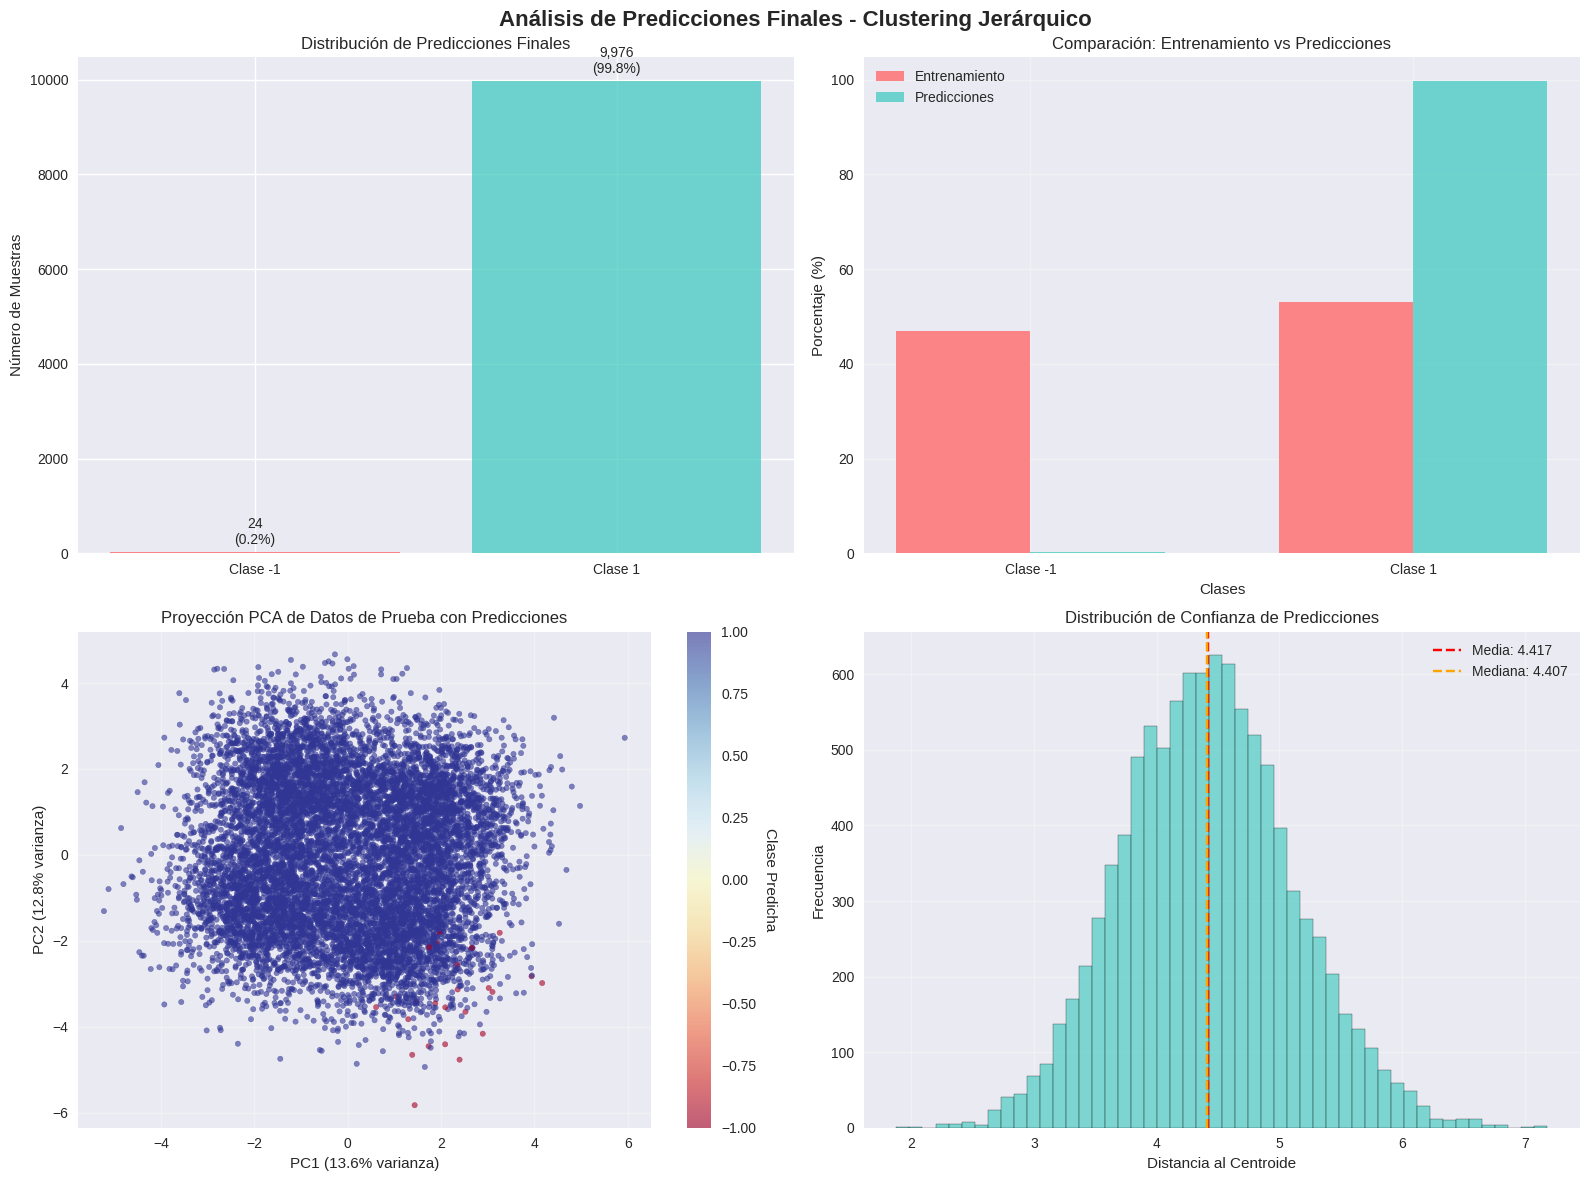


ESTADÍSTICAS DETALLADAS DE PREDICCIONES:
--------------------------------------------------
Total de muestras procesadas: 10,000
Algoritmo utilizado: HIERARCHICAL
Configuración del modelo: {'n_clusters': 2, 'linkage': 'average'}

Distribución detallada por clase:
   Clase -1:     24 muestras (  0.24%)
   Clase  1:  9,976 muestras ( 99.76%)

Comparación con distribución original:
   Clase -1: Train= 46.9% | Pred=  0.2% | Diff=-46.7%
   Clase  1: Train= 53.1% | Pred= 99.8% | Diff=+46.7%

ANÁLISIS DE CALIDAD:
   Distancia promedio al centroide: 4.4173
   Desviación estándar: 0.6918
   Percentil 95 de distancias: 5.5973
   Muestras con alta incertidumbre (>p95): 500 (5.0%)

MAPEO FINAL DE CLUSTERS:
   Cluster 0 -> Clase 1 | 9,976 muestras (99.8%)
   Cluster 1 -> Clase -1 | 24 muestras (0.2%)

ANÁLISIS DE PREDICCIONES COMPLETADO
Archivo analizado: 06.mat
Figures guardadas en: figures/figura_04_analisis_predicciones_finales.png


In [31]:
# ================================
# EDA DEL ARCHIVO .MAT GENERADO
# ================================

print("ANÁLISIS EXPLORATORIO DE LAS PREDICCIONES FINALES")
print("="*60)

# Cargar el archivo .mat generado
try:
    predicciones_mat = loadmat('06.mat')
    print("Archivo 06.mat cargado exitosamente")
    
    # Mostrar todas las claves disponibles
    print(f"\nClaves disponibles en 06.mat:")
    for key in predicciones_mat.keys():
        if not key.startswith('__'):
            print(f"   {key}: {type(predicciones_mat[key])}")
    
    # Extraer las predicciones
    y_pred_loaded = predicciones_mat['y_test_pred'].flatten()
    algoritmo_usado = predicciones_mat['algoritmo_usado']
    parametros = predicciones_mat['parametros']
    
    print(f"\nInformación del modelo usado:")
    print(f"   Algoritmo: {algoritmo_usado}")
    print(f"   Parámetros: {parametros}")
    if 'accuracy_cv' in predicciones_mat:
        print(f"   Accuracy CV: {predicciones_mat['accuracy_cv'][0][0]:.4f}")
    if 'silhouette_score' in predicciones_mat:
        print(f"   Silhouette Score: {predicciones_mat['silhouette_score'][0][0]:.4f}")
    
except Exception as e:
    print(f"Error cargando el archivo: {e}")
    y_pred_loaded = final_predictions  # Usar las predicciones en memoria

print(f"\nAnálisis de las predicciones:")
print(f"   Forma: {y_pred_loaded.shape}")
print(f"   Tipo de datos: {y_pred_loaded.dtype}")
print(f"   Valores únicos: {np.unique(y_pred_loaded)}")
print(f"   Rango: [{y_pred_loaded.min()}, {y_pred_loaded.max()}]")

# Análisis estadístico de las predicciones
unique_predictions, counts_predictions = np.unique(y_pred_loaded, return_counts=True)
print(f"\nDistribución de predicciones:")
for pred, count in zip(unique_predictions, counts_predictions):
    percentage = count / len(y_pred_loaded) * 100
    print(f"   Clase {int(pred)}: {count:,} muestras ({percentage:.2f}%)")

# Crear figura para visualizar las predicciones
fig4, axes4 = plt.subplots(2, 2, figsize=(16, 12))
fig4.suptitle('Análisis de Predicciones Finales - Clustering Jerárquico', fontsize=16, fontweight='bold')

# 1. Distribución de predicciones
ax1 = axes4[0, 0]
colors_pred = ['#FF6B6B', '#4ECDC4']
bars = ax1.bar([f'Clase {int(pred)}' for pred in unique_predictions], 
               counts_predictions, color=colors_pred, alpha=0.8)
ax1.set_title('Distribución de Predicciones Finales')
ax1.set_ylabel('Número de Muestras')
for i, (bar, count, pred) in enumerate(zip(bars, counts_predictions, unique_predictions)):
    height = bar.get_height()
    percentage = height / len(y_pred_loaded) * 100
    ax1.text(bar.get_x() + bar.get_width()/2., height + len(y_pred_loaded)*0.01, 
             f'{count:,}\n({percentage:.1f}%)', ha='center', va='bottom')

# 2. Comparación con distribución original de entrenamiento
ax2 = axes4[0, 1]
# Distribución original
train_unique, train_counts = np.unique(y_train, return_counts=True)
train_percentages = train_counts / len(y_train) * 100
pred_percentages = counts_predictions / len(y_pred_loaded) * 100

x_pos = np.arange(len(unique_predictions))
width = 0.35

bars1 = ax2.bar(x_pos - width/2, train_percentages, width, 
                label='Entrenamiento', alpha=0.8, color='#FF6B6B')
bars2 = ax2.bar(x_pos + width/2, pred_percentages, width, 
                label='Predicciones', alpha=0.8, color='#4ECDC4')

ax2.set_xlabel('Clases')
ax2.set_ylabel('Porcentaje (%)')
ax2.set_title('Comparación: Entrenamiento vs Predicciones')
ax2.set_xticks(x_pos)
ax2.set_xticklabels([f'Clase {int(pred)}' for pred in unique_predictions])
ax2.legend()
ax2.grid(True, alpha=0.3)

# 3. Proyección PCA de predicciones
ax3 = axes4[1, 0]
# Usar PCA ya entrenado para proyectar datos de prueba
X_test_pca_pred = pca_full.transform(X_test)

# Colorear según las predicciones
scatter_pred = ax3.scatter(X_test_pca_pred[:, 0], X_test_pca_pred[:, 1], 
                          c=y_pred_loaded, cmap='RdYlBu', alpha=0.6, s=15)
ax3.set_xlabel(f'PC1 ({pca_full.explained_variance_ratio_[0]:.1%} varianza)')
ax3.set_ylabel(f'PC2 ({pca_full.explained_variance_ratio_[1]:.1%} varianza)')
ax3.set_title('Proyección PCA de Datos de Prueba con Predicciones')
ax3.grid(True, alpha=0.3)
cbar_pred = plt.colorbar(scatter_pred, ax=ax3)
cbar_pred.set_label('Clase Predicha', rotation=270, labelpad=15)

# 4. Análisis de confianza de predicciones (basado en distancia a centroides)
ax4 = axes4[1, 1]

# Calcular centroides de clusters en datos de entrenamiento
cluster_labels_train = final_results[best_model_name]['train_clusters']
centroids = {}
for cluster_id in np.unique(cluster_labels_train):
    mask = cluster_labels_train == cluster_id
    centroid = X_train_scaled[mask].mean(axis=0)
    centroids[cluster_id] = centroid

# Calcular distancias de cada muestra de prueba a su centroide asignado
test_clusters = final_results[best_model_name]['test_clusters']
distances_to_centroid = []

for i, (cluster_id, sample) in enumerate(zip(test_clusters, X_test_scaled)):
    if cluster_id in centroids:
        distance = np.linalg.norm(sample - centroids[cluster_id])
        distances_to_centroid.append(distance)
    else:
        distances_to_centroid.append(np.nan)

distances_to_centroid = np.array(distances_to_centroid)
valid_distances = distances_to_centroid[~np.isnan(distances_to_centroid)]

# Histograma de distancias
ax4.hist(valid_distances, bins=50, alpha=0.7, color='#4ECDC4', edgecolor='black')
ax4.axvline(np.mean(valid_distances), color='red', linestyle='--', 
           label=f'Media: {np.mean(valid_distances):.3f}')
ax4.axvline(np.median(valid_distances), color='orange', linestyle='--', 
           label=f'Mediana: {np.median(valid_distances):.3f}')
ax4.set_xlabel('Distancia al Centroide')
ax4.set_ylabel('Frecuencia')
ax4.set_title('Distribución de Confianza de Predicciones')
ax4.legend()
ax4.grid(True, alpha=0.3)

plt.tight_layout()
plt.savefig(figures_dir / 'figura_04_analisis_predicciones_finales.png', dpi=300, bbox_inches='tight')
plt.show()

# Estadísticas detalladas
print(f"\nESTADÍSTICAS DETALLADAS DE PREDICCIONES:")
print("-" * 50)
print(f"Total de muestras procesadas: {len(y_pred_loaded):,}")
print(f"Algoritmo utilizado: {best_model_name.upper()}")
print(f"Configuración del modelo: {final_results[best_model_name]['params']}")

print(f"\nDistribución detallada por clase:")
for pred, count in zip(unique_predictions, counts_predictions):
    percentage = count / len(y_pred_loaded) * 100
    print(f"   Clase {int(pred):2d}: {count:6,} muestras ({percentage:6.2f}%)")

print(f"\nComparación con distribución original:")
for i, (pred, train_pct, pred_pct) in enumerate(zip(unique_predictions, train_percentages, pred_percentages)):
    diff = pred_pct - train_pct
    print(f"   Clase {int(pred):2d}: Train={train_pct:5.1f}% | Pred={pred_pct:5.1f}% | Diff={diff:+5.1f}%")

# Análisis de calidad de predicciones
print(f"\nANÁLISIS DE CALIDAD:")
print(f"   Distancia promedio al centroide: {np.mean(valid_distances):.4f}")
print(f"   Desviación estándar: {np.std(valid_distances):.4f}")
print(f"   Percentil 95 de distancias: {np.percentile(valid_distances, 95):.4f}")

# Detección de posibles outliers
outlier_threshold = np.percentile(valid_distances, 95)
n_outliers = np.sum(valid_distances > outlier_threshold)
print(f"   Muestras con alta incertidumbre (>p95): {n_outliers} ({n_outliers/len(valid_distances)*100:.1f}%)")

# Resumen de mapeo de clusters
print(f"\nMAPEO FINAL DE CLUSTERS:")
cluster_mapping = final_results[best_model_name]['cluster_mapping']
for cluster_id, label in cluster_mapping.items():
    count_in_cluster = np.sum(test_clusters == cluster_id) if cluster_id != -1 else 0
    percentage_in_cluster = count_in_cluster / len(test_clusters) * 100 if len(test_clusters) > 0 else 0
    print(f"   Cluster {cluster_id} -> Clase {label} | {count_in_cluster:,} muestras ({percentage_in_cluster:.1f}%)")

print(f"\nANÁLISIS DE PREDICCIONES COMPLETADO")
print(f"Archivo analizado: 06.mat")
print(f"Figures guardadas en: {figures_dir}/figura_04_analisis_predicciones_finales.png")